computation time = 0.20418477058410645
computation time = 0.36554408073425293
computation time = 1.9305450916290283
computation time = 14.583468198776245
computation time = 129.91898393630981
[[0.023230298736033175, 0.04199507652559487], [0.011594972238695954, 0.02252575645826878], [0.005768564588375166, 0.01195572919153168], [0.002853464978188796, 0.006235438511556019], [0.0013962197092010633, 0.003184183207293886]]
convergence order for s(t)= 1.0
convergence order for u = 0.9
convergence order for s(t)= 1.01
convergence order for u = 0.91
convergence order for s(t)= 1.02
convergence order for u = 0.94
convergence order for s(t)= 1.03
convergence order for u = 0.97


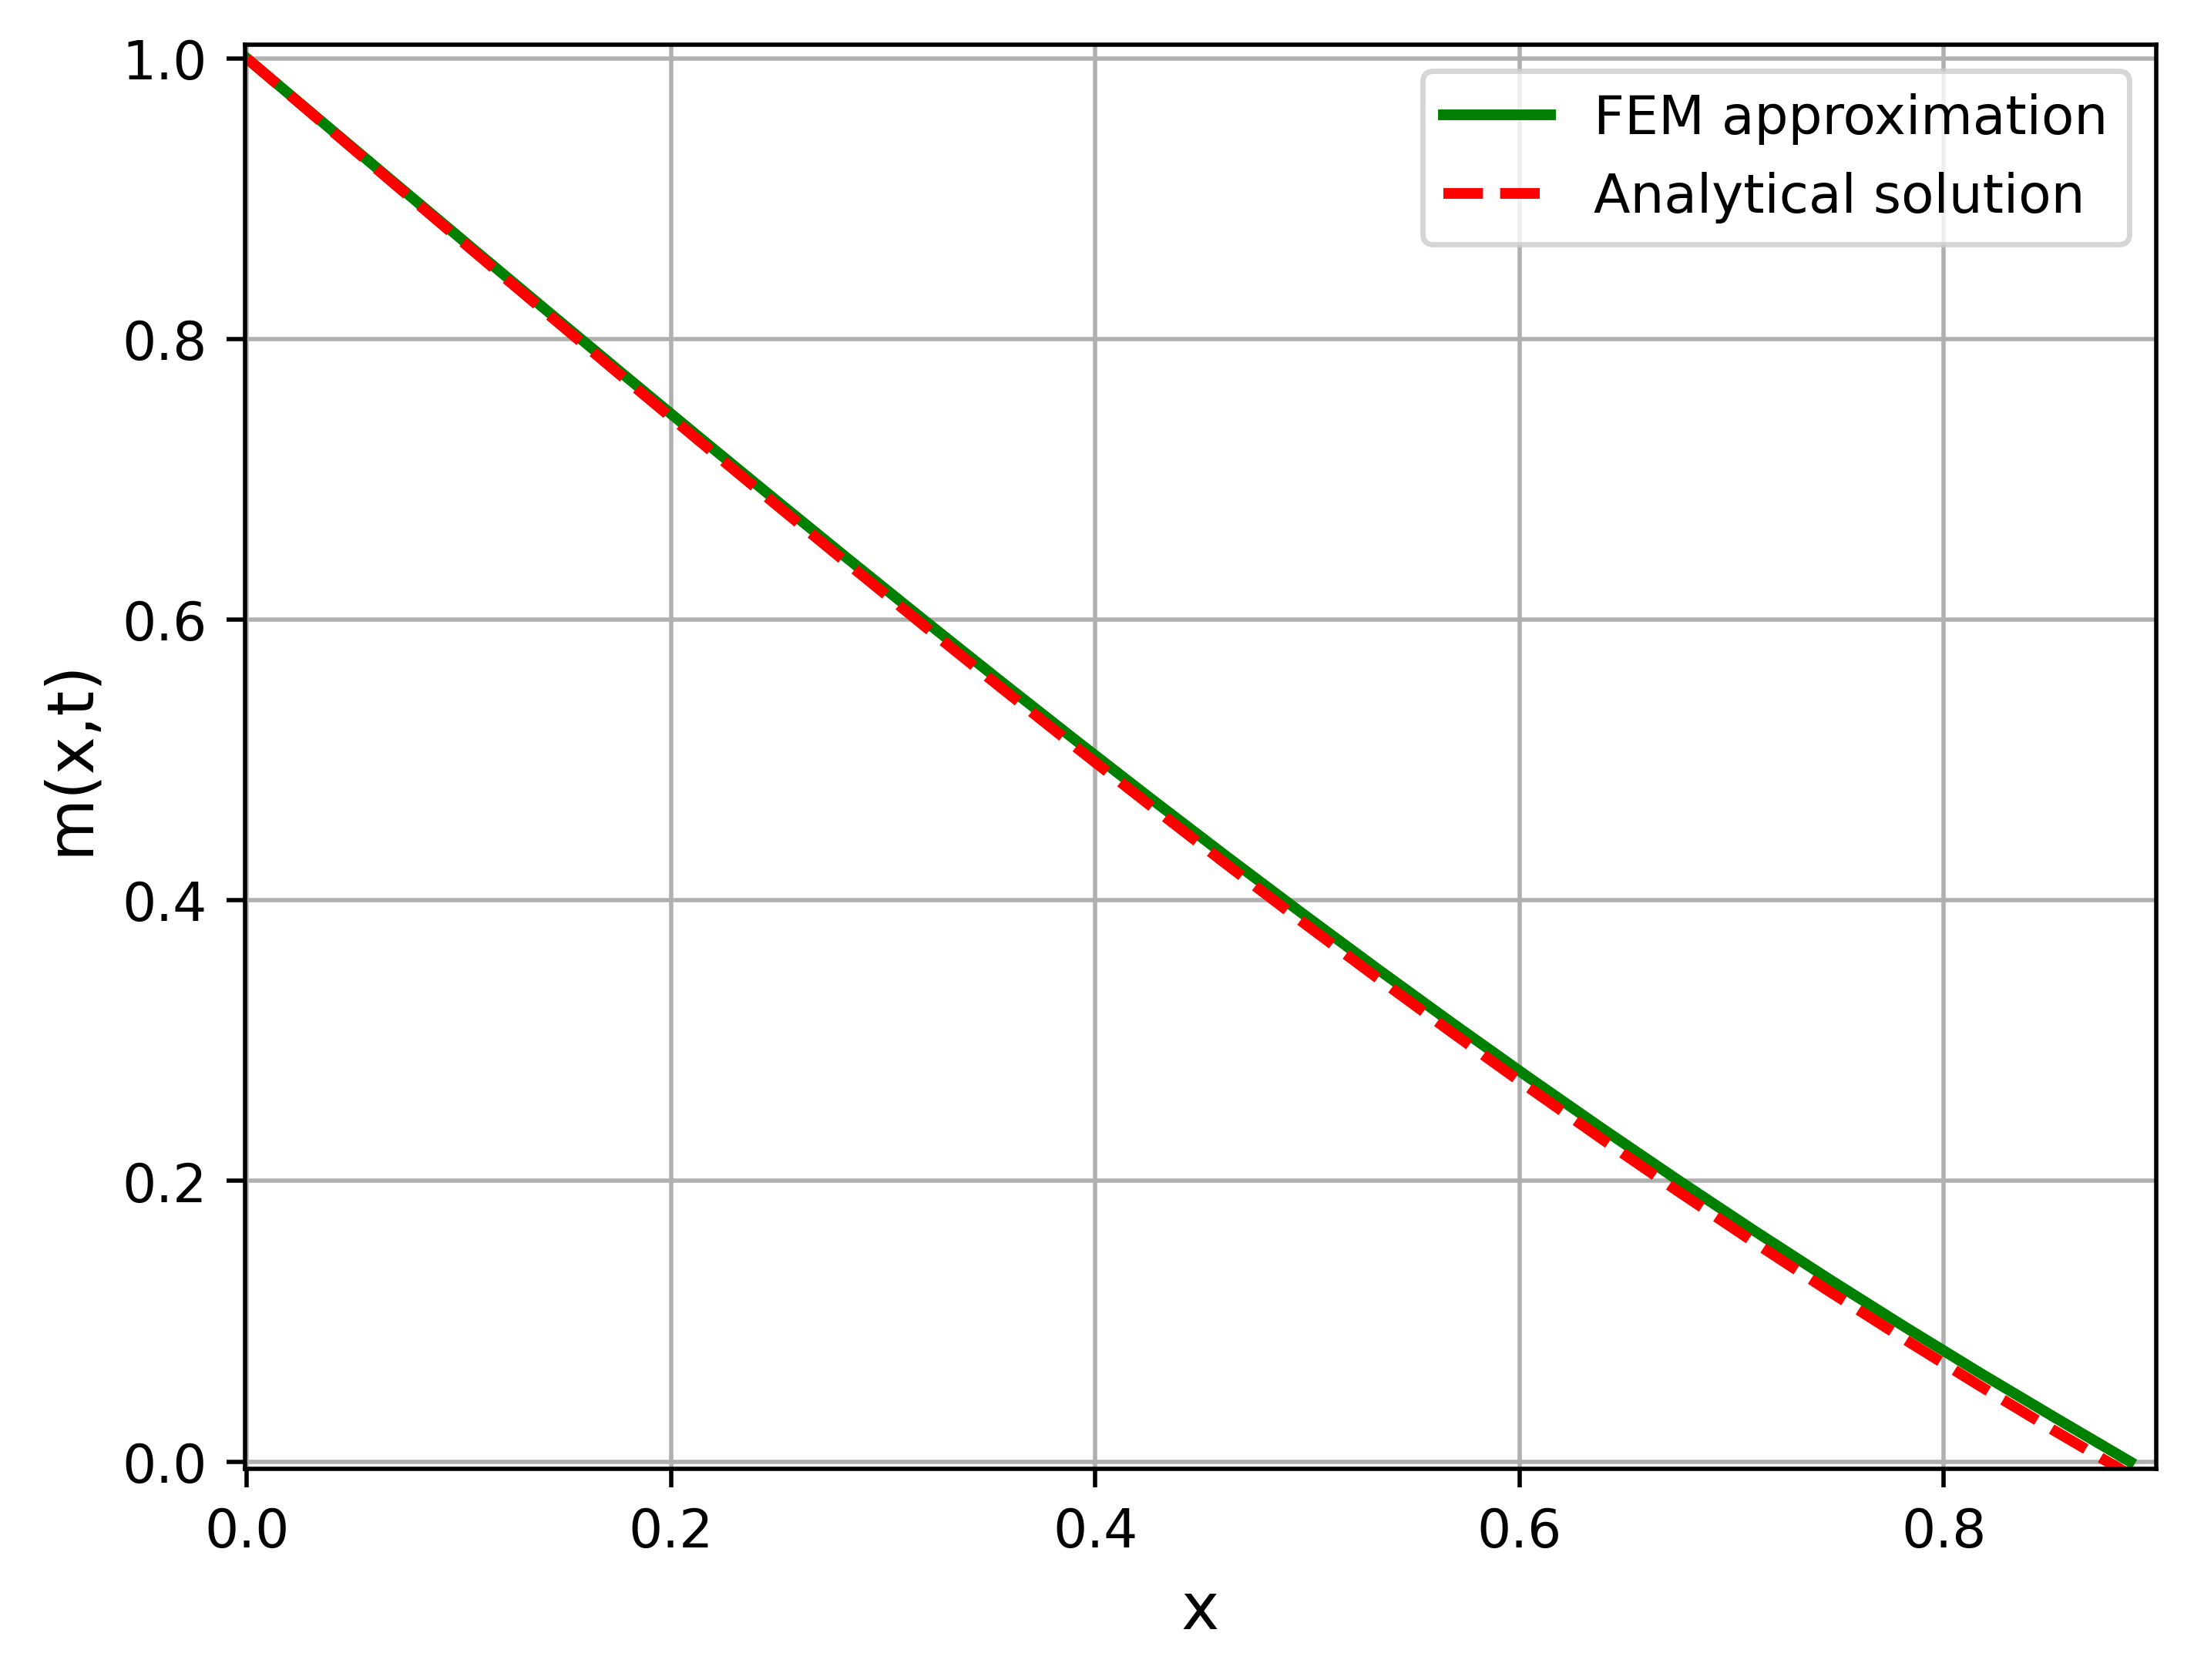

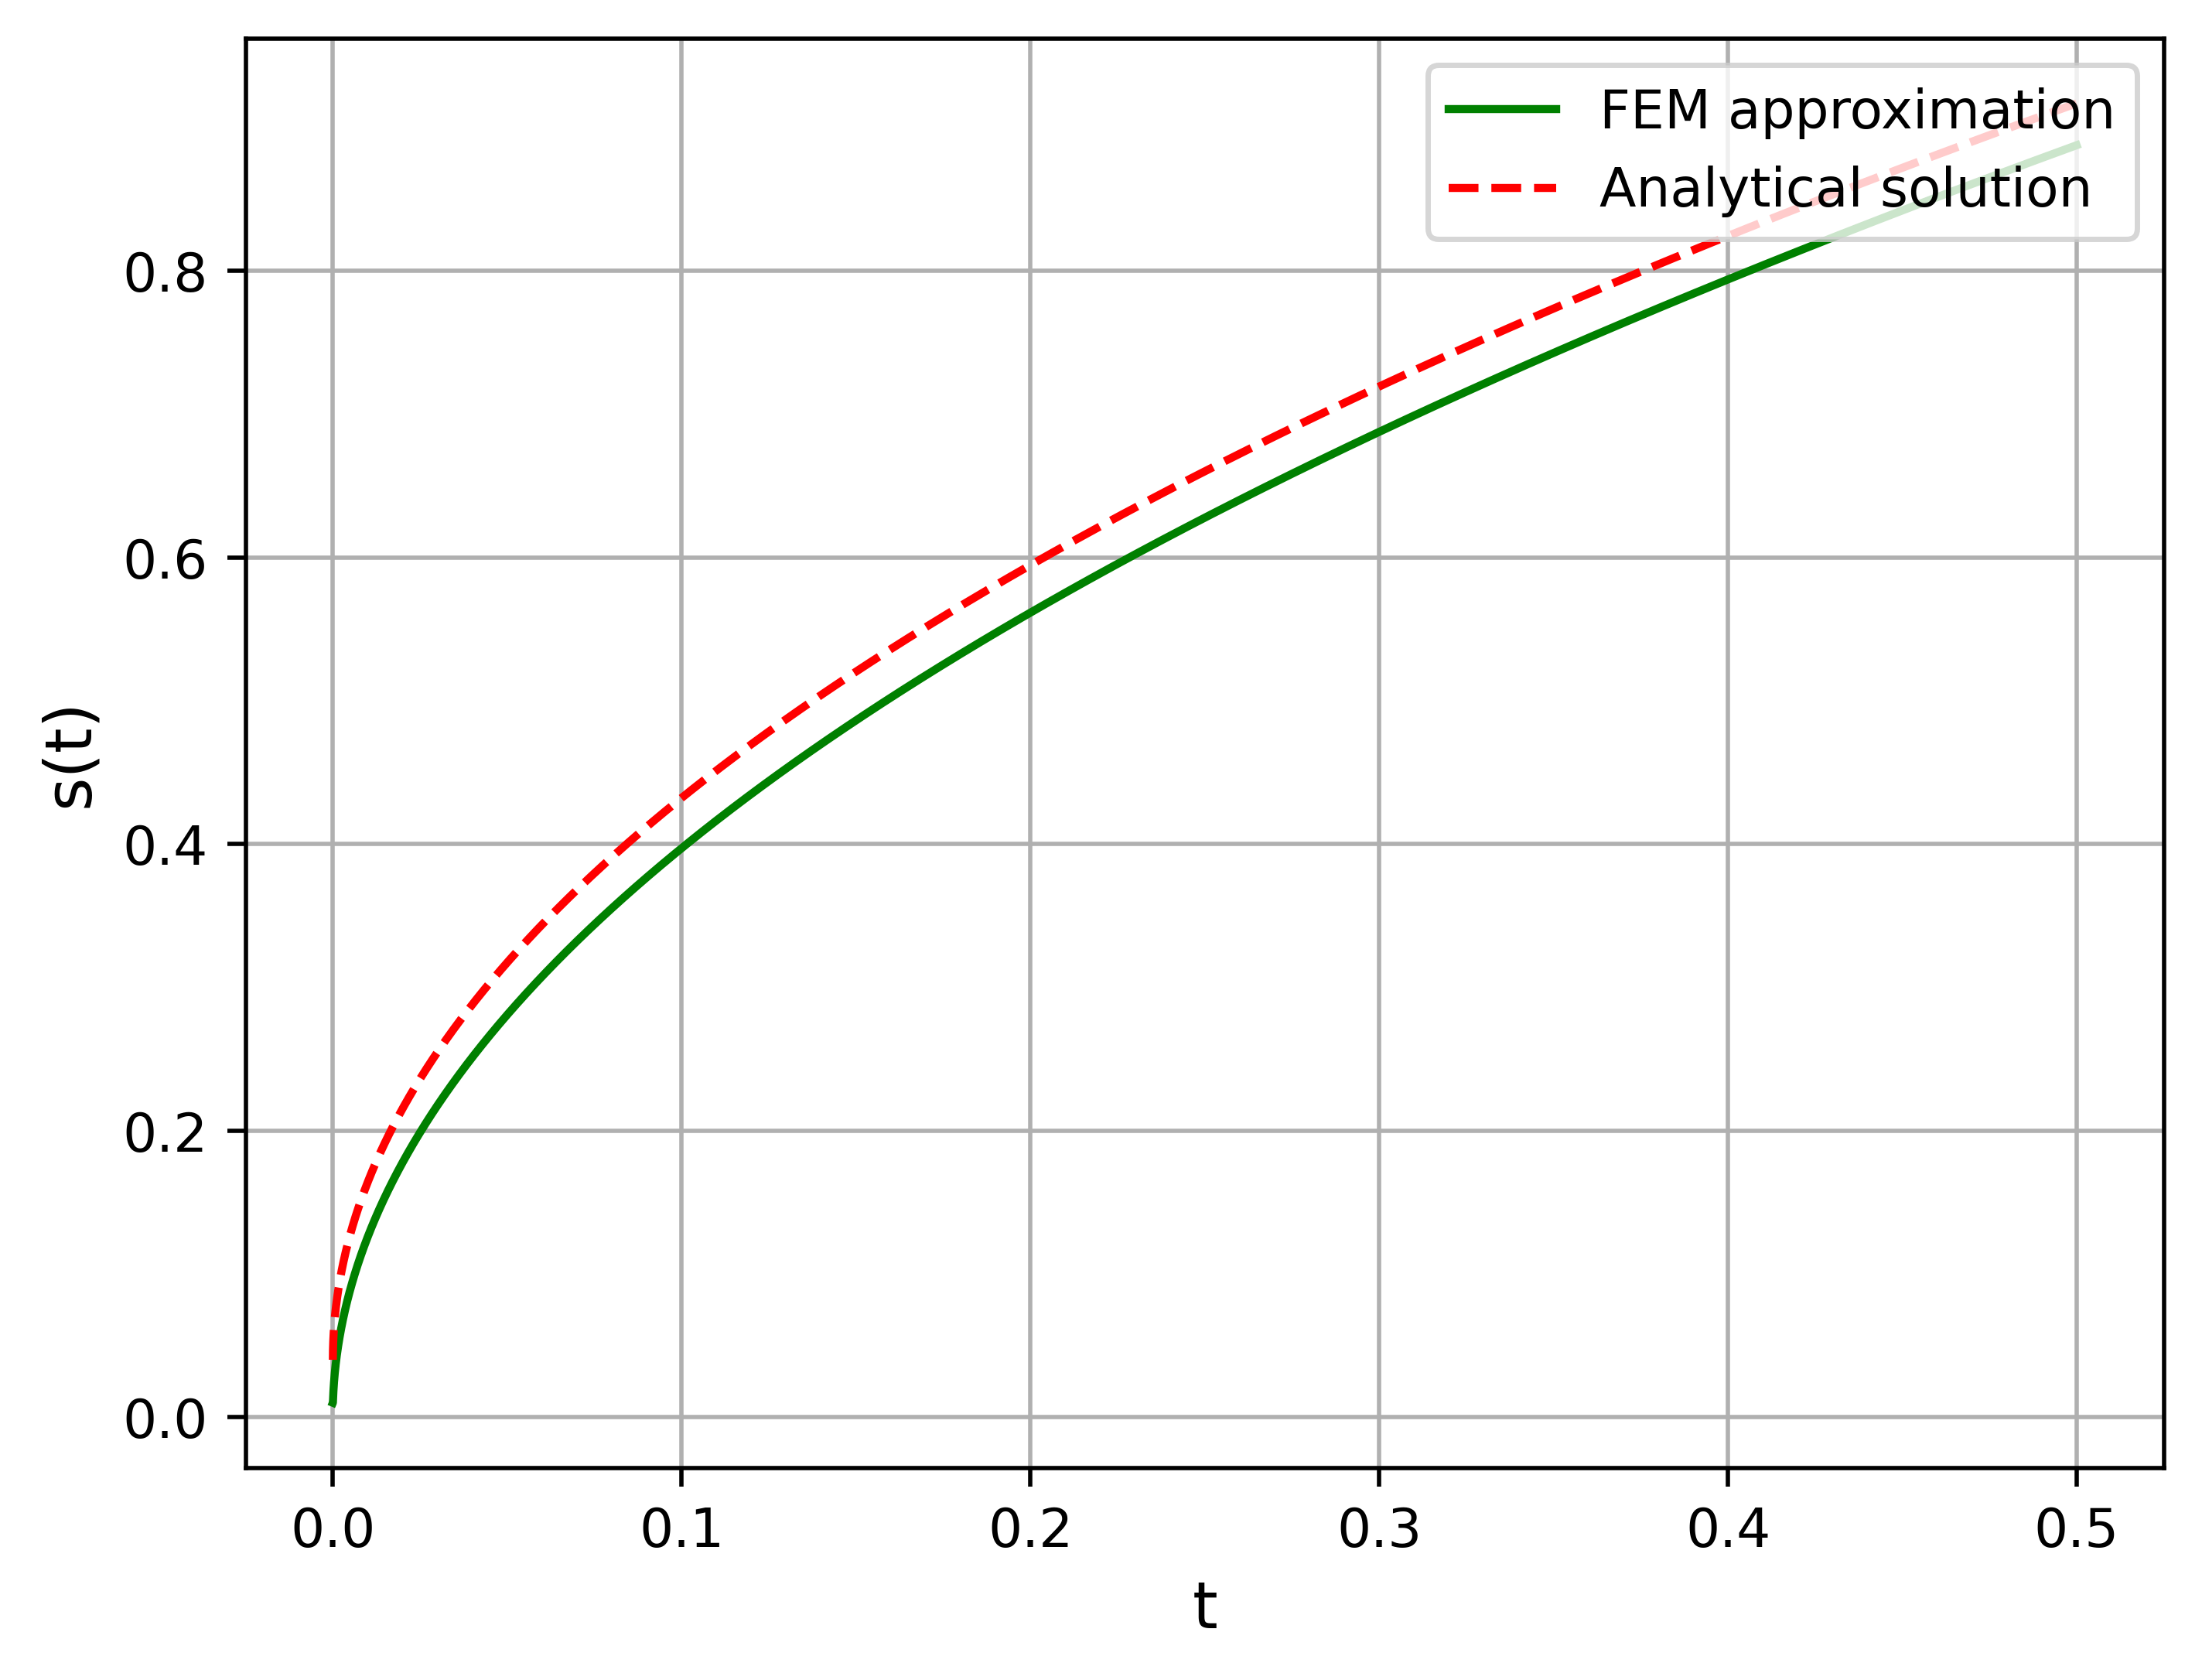

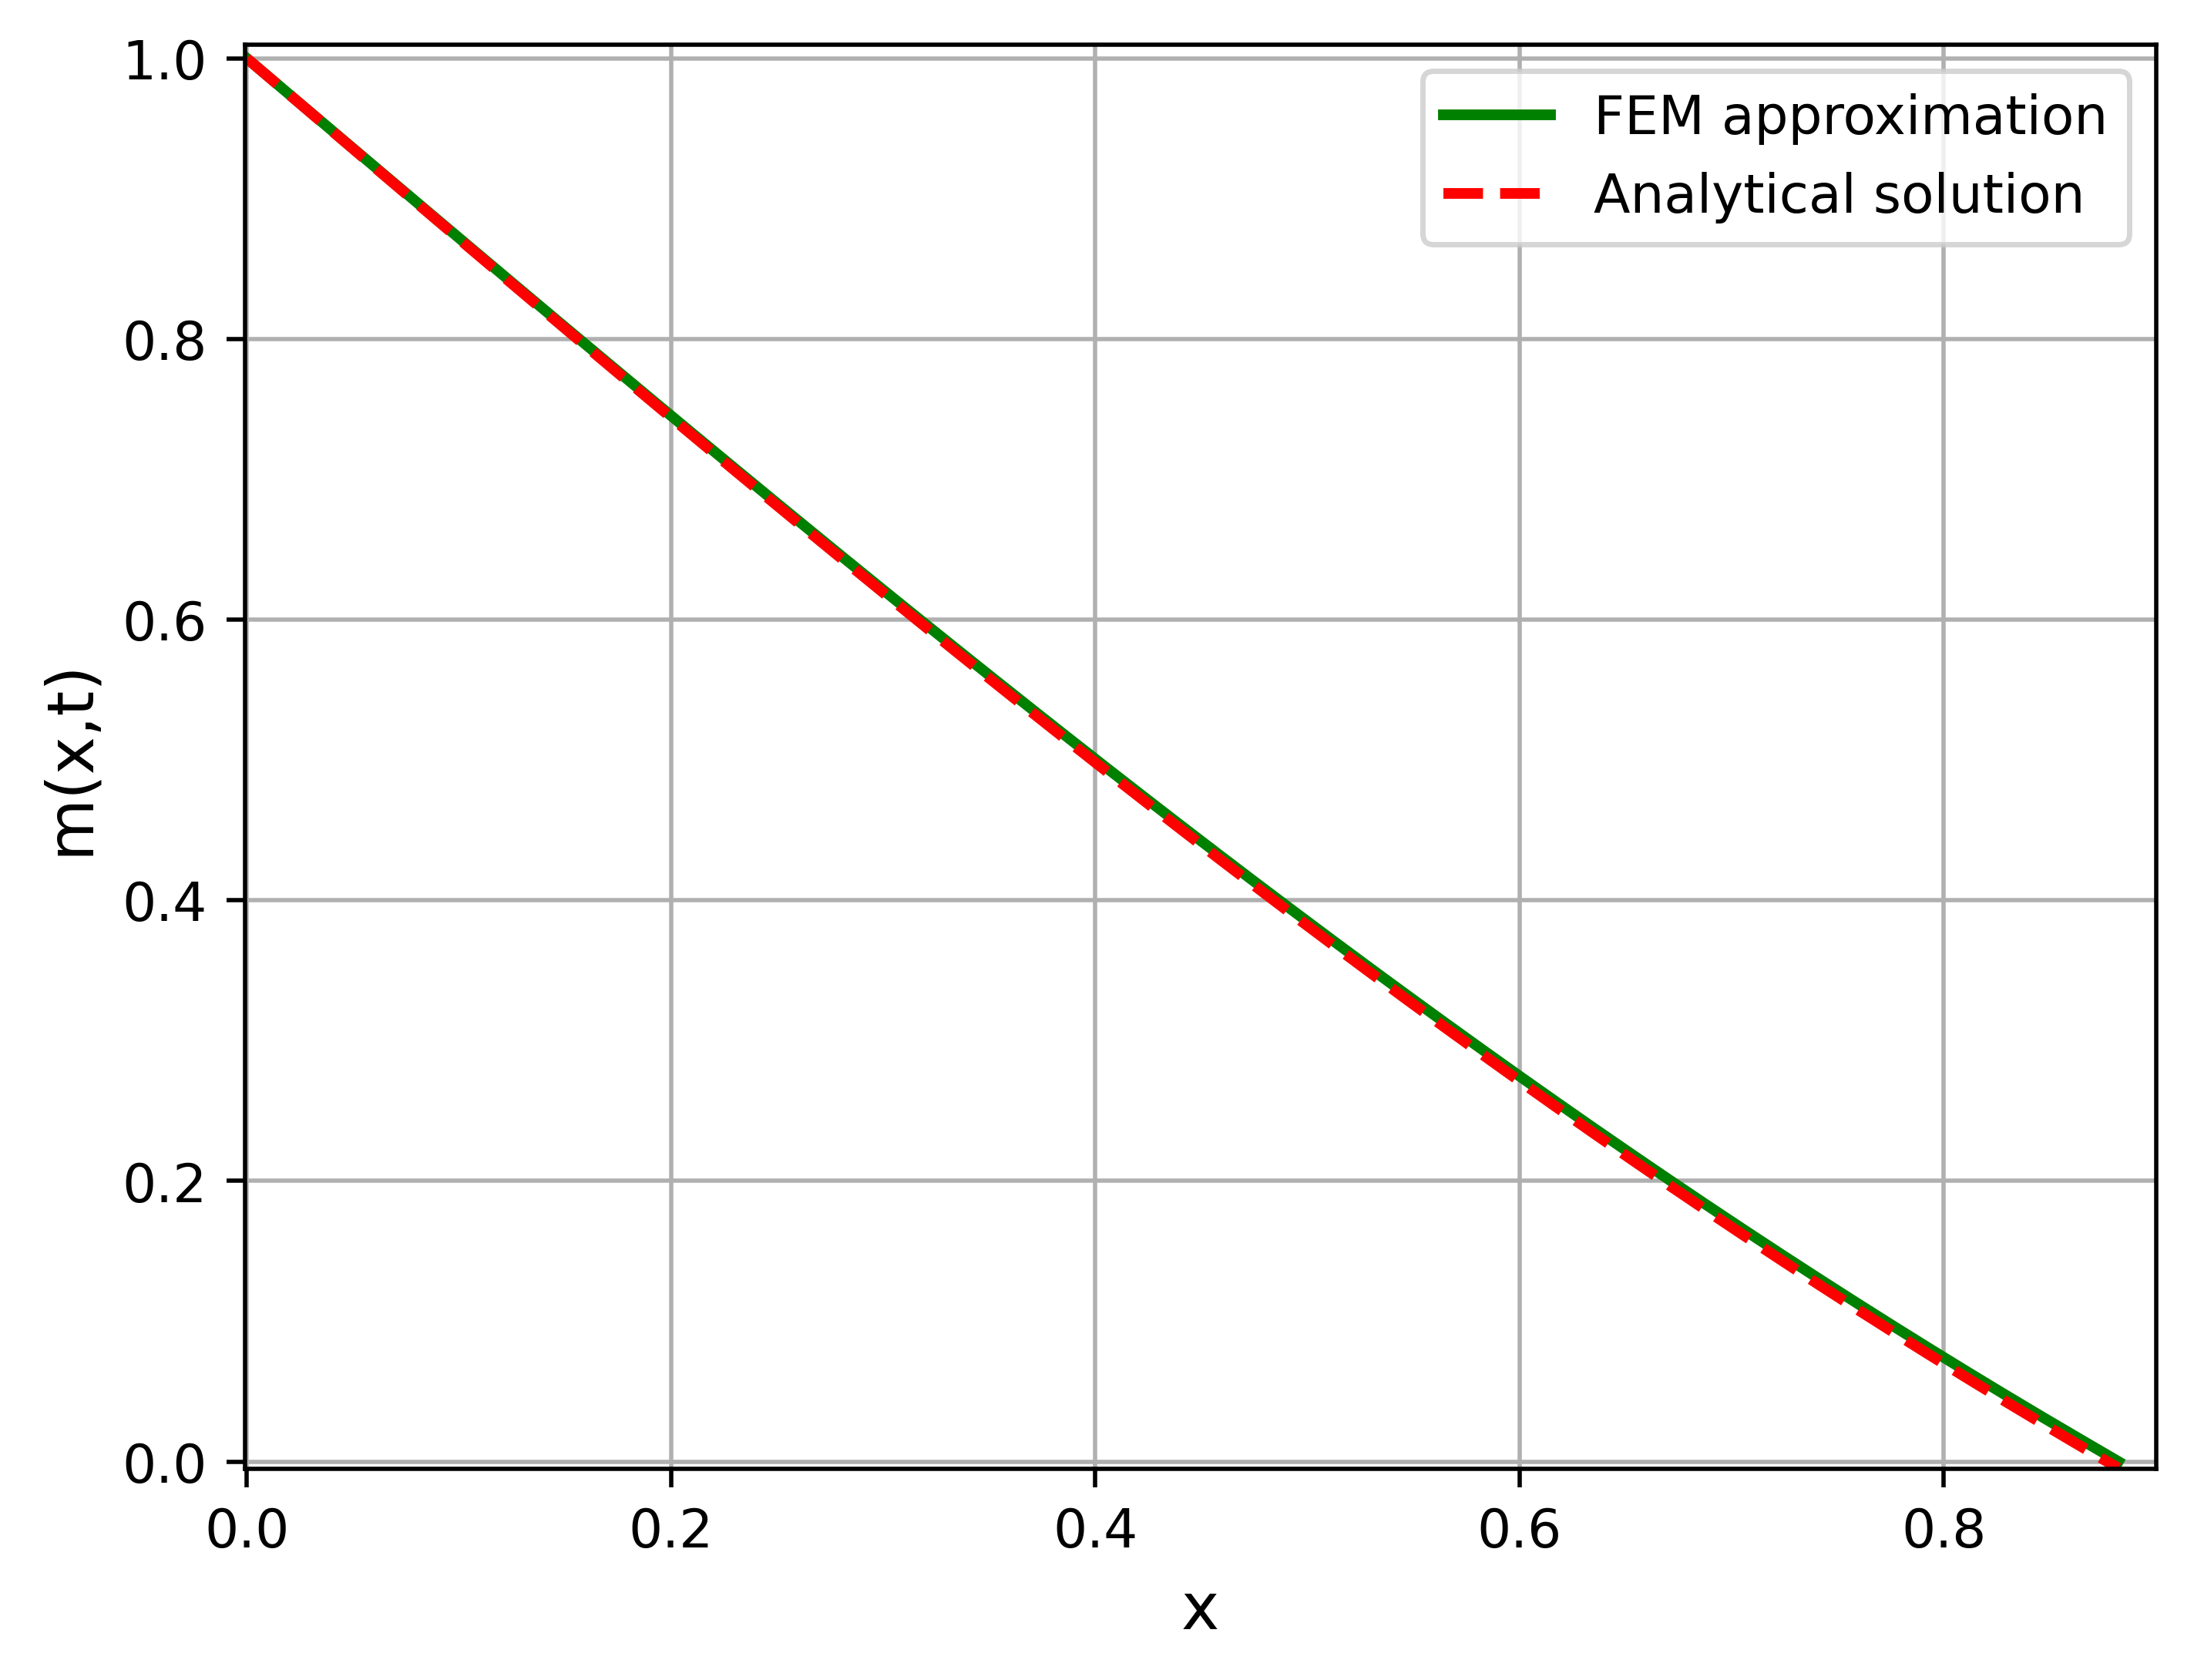

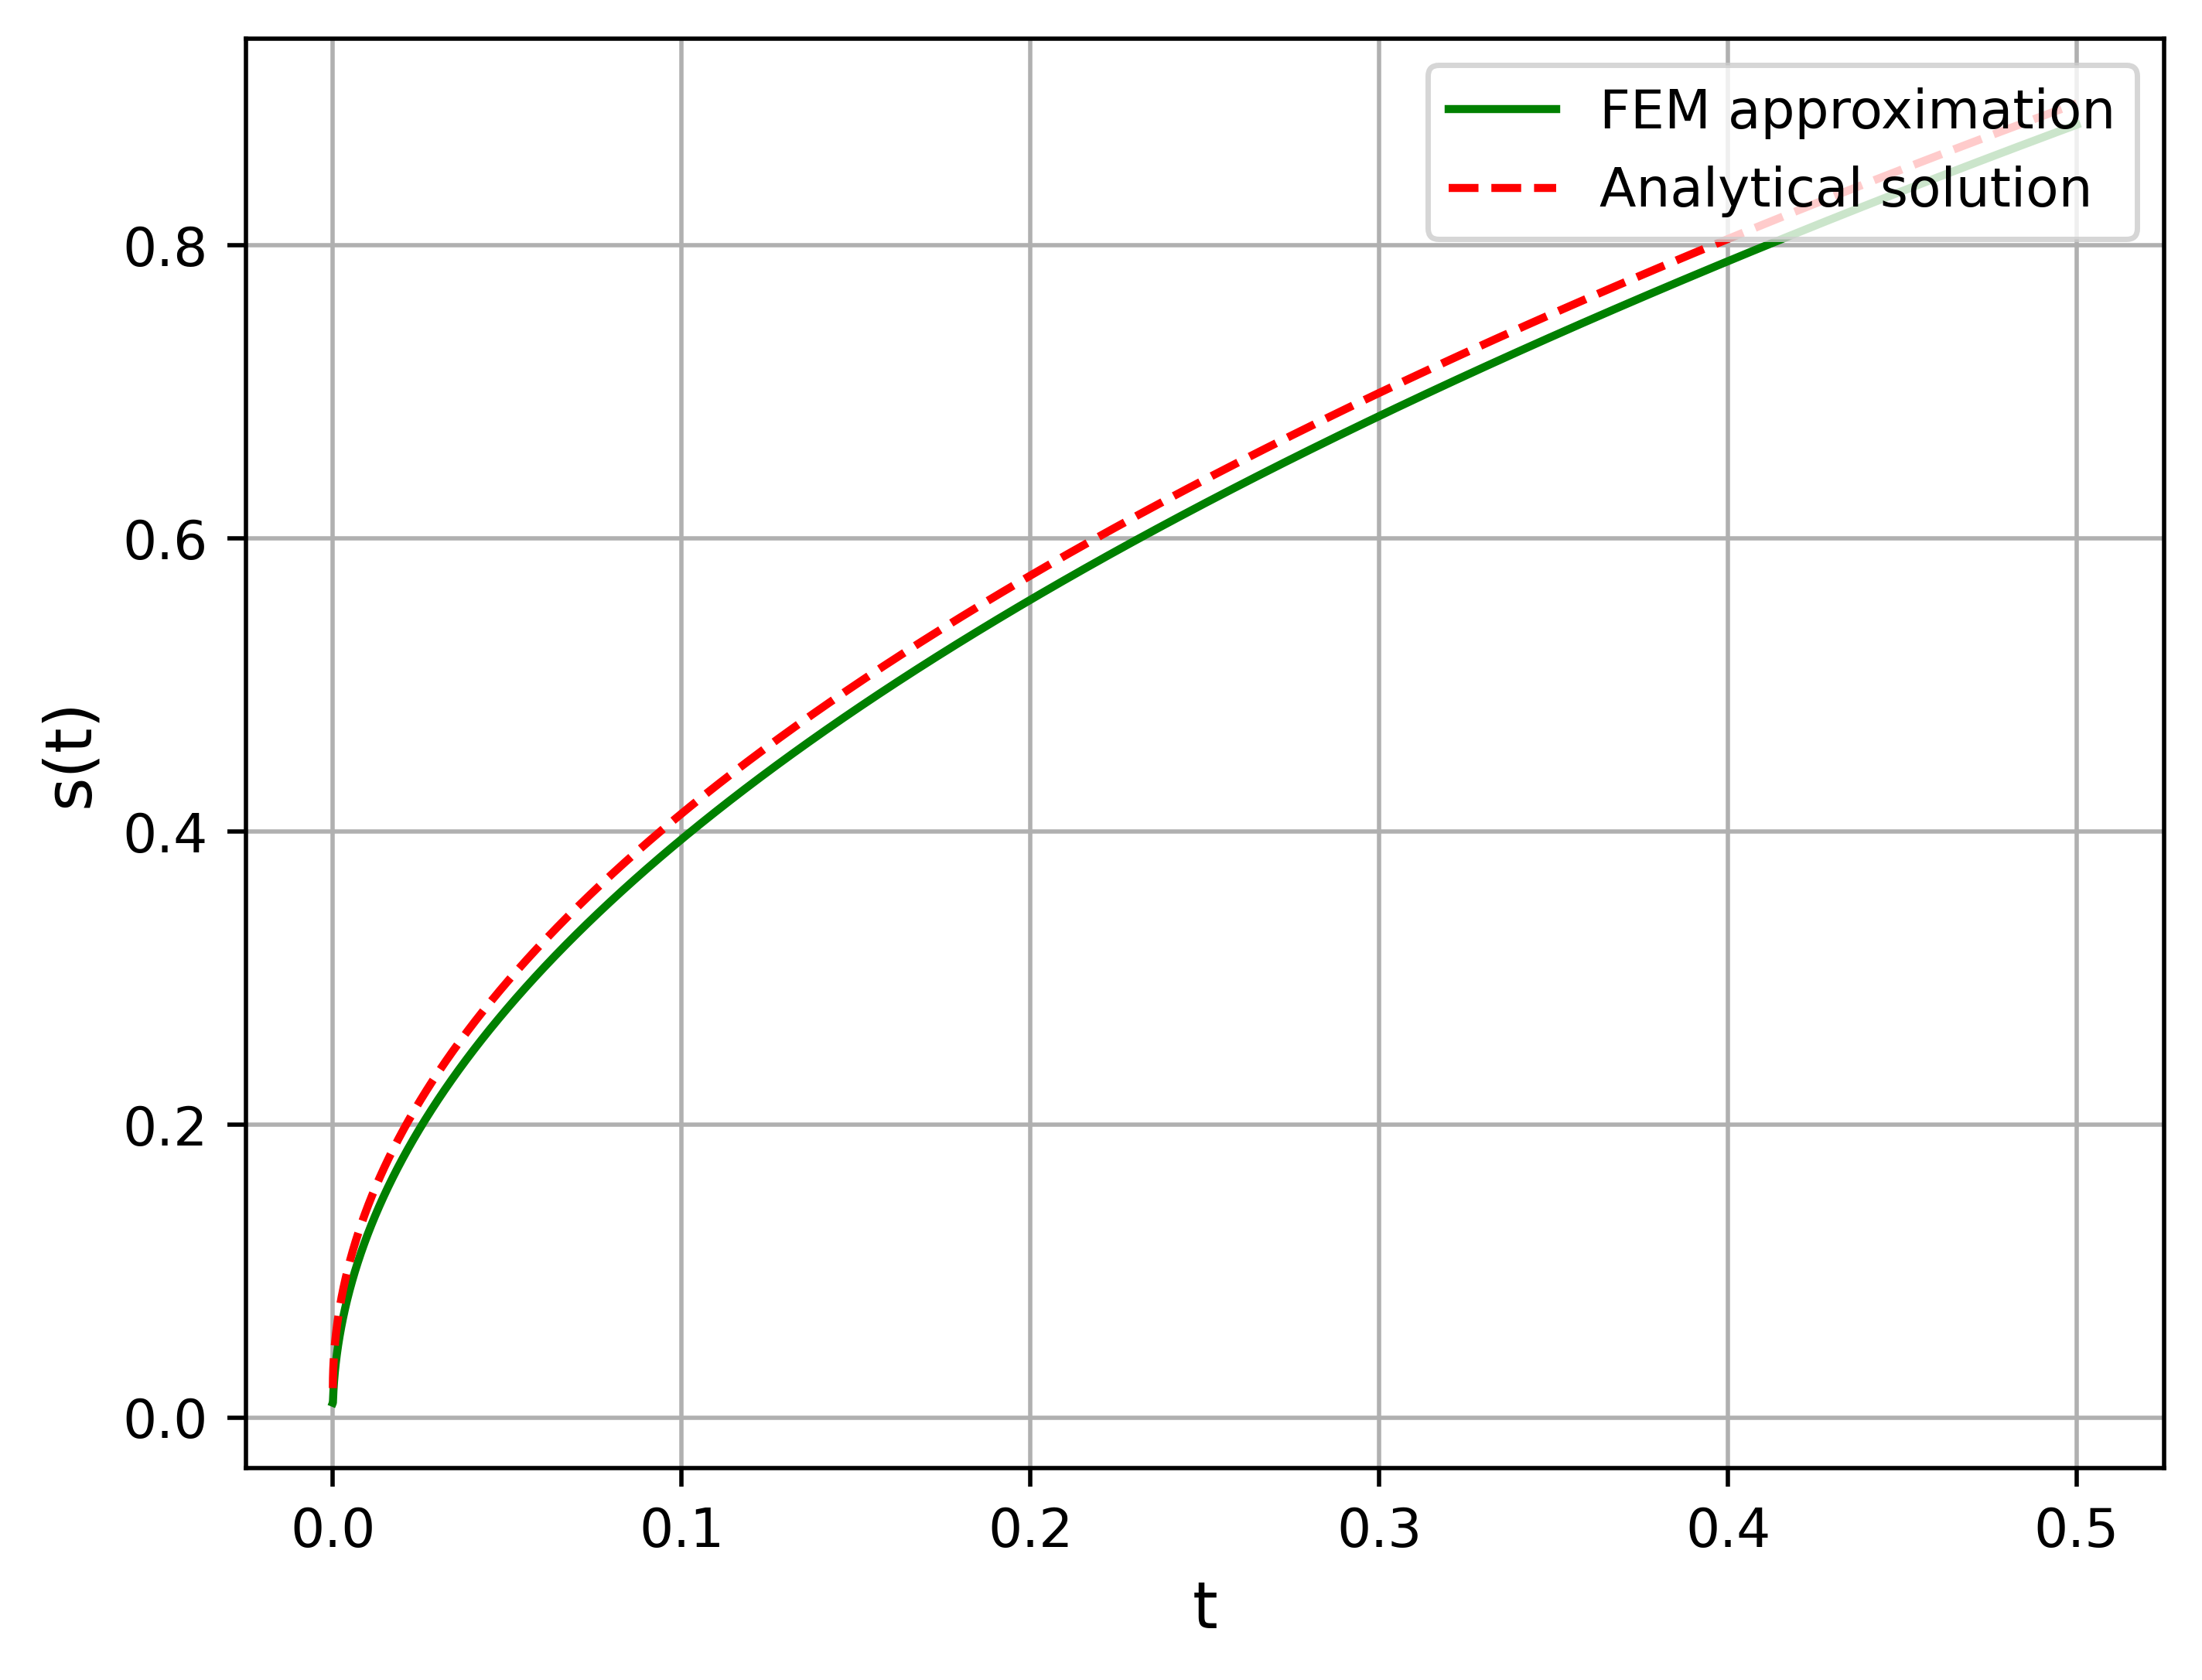

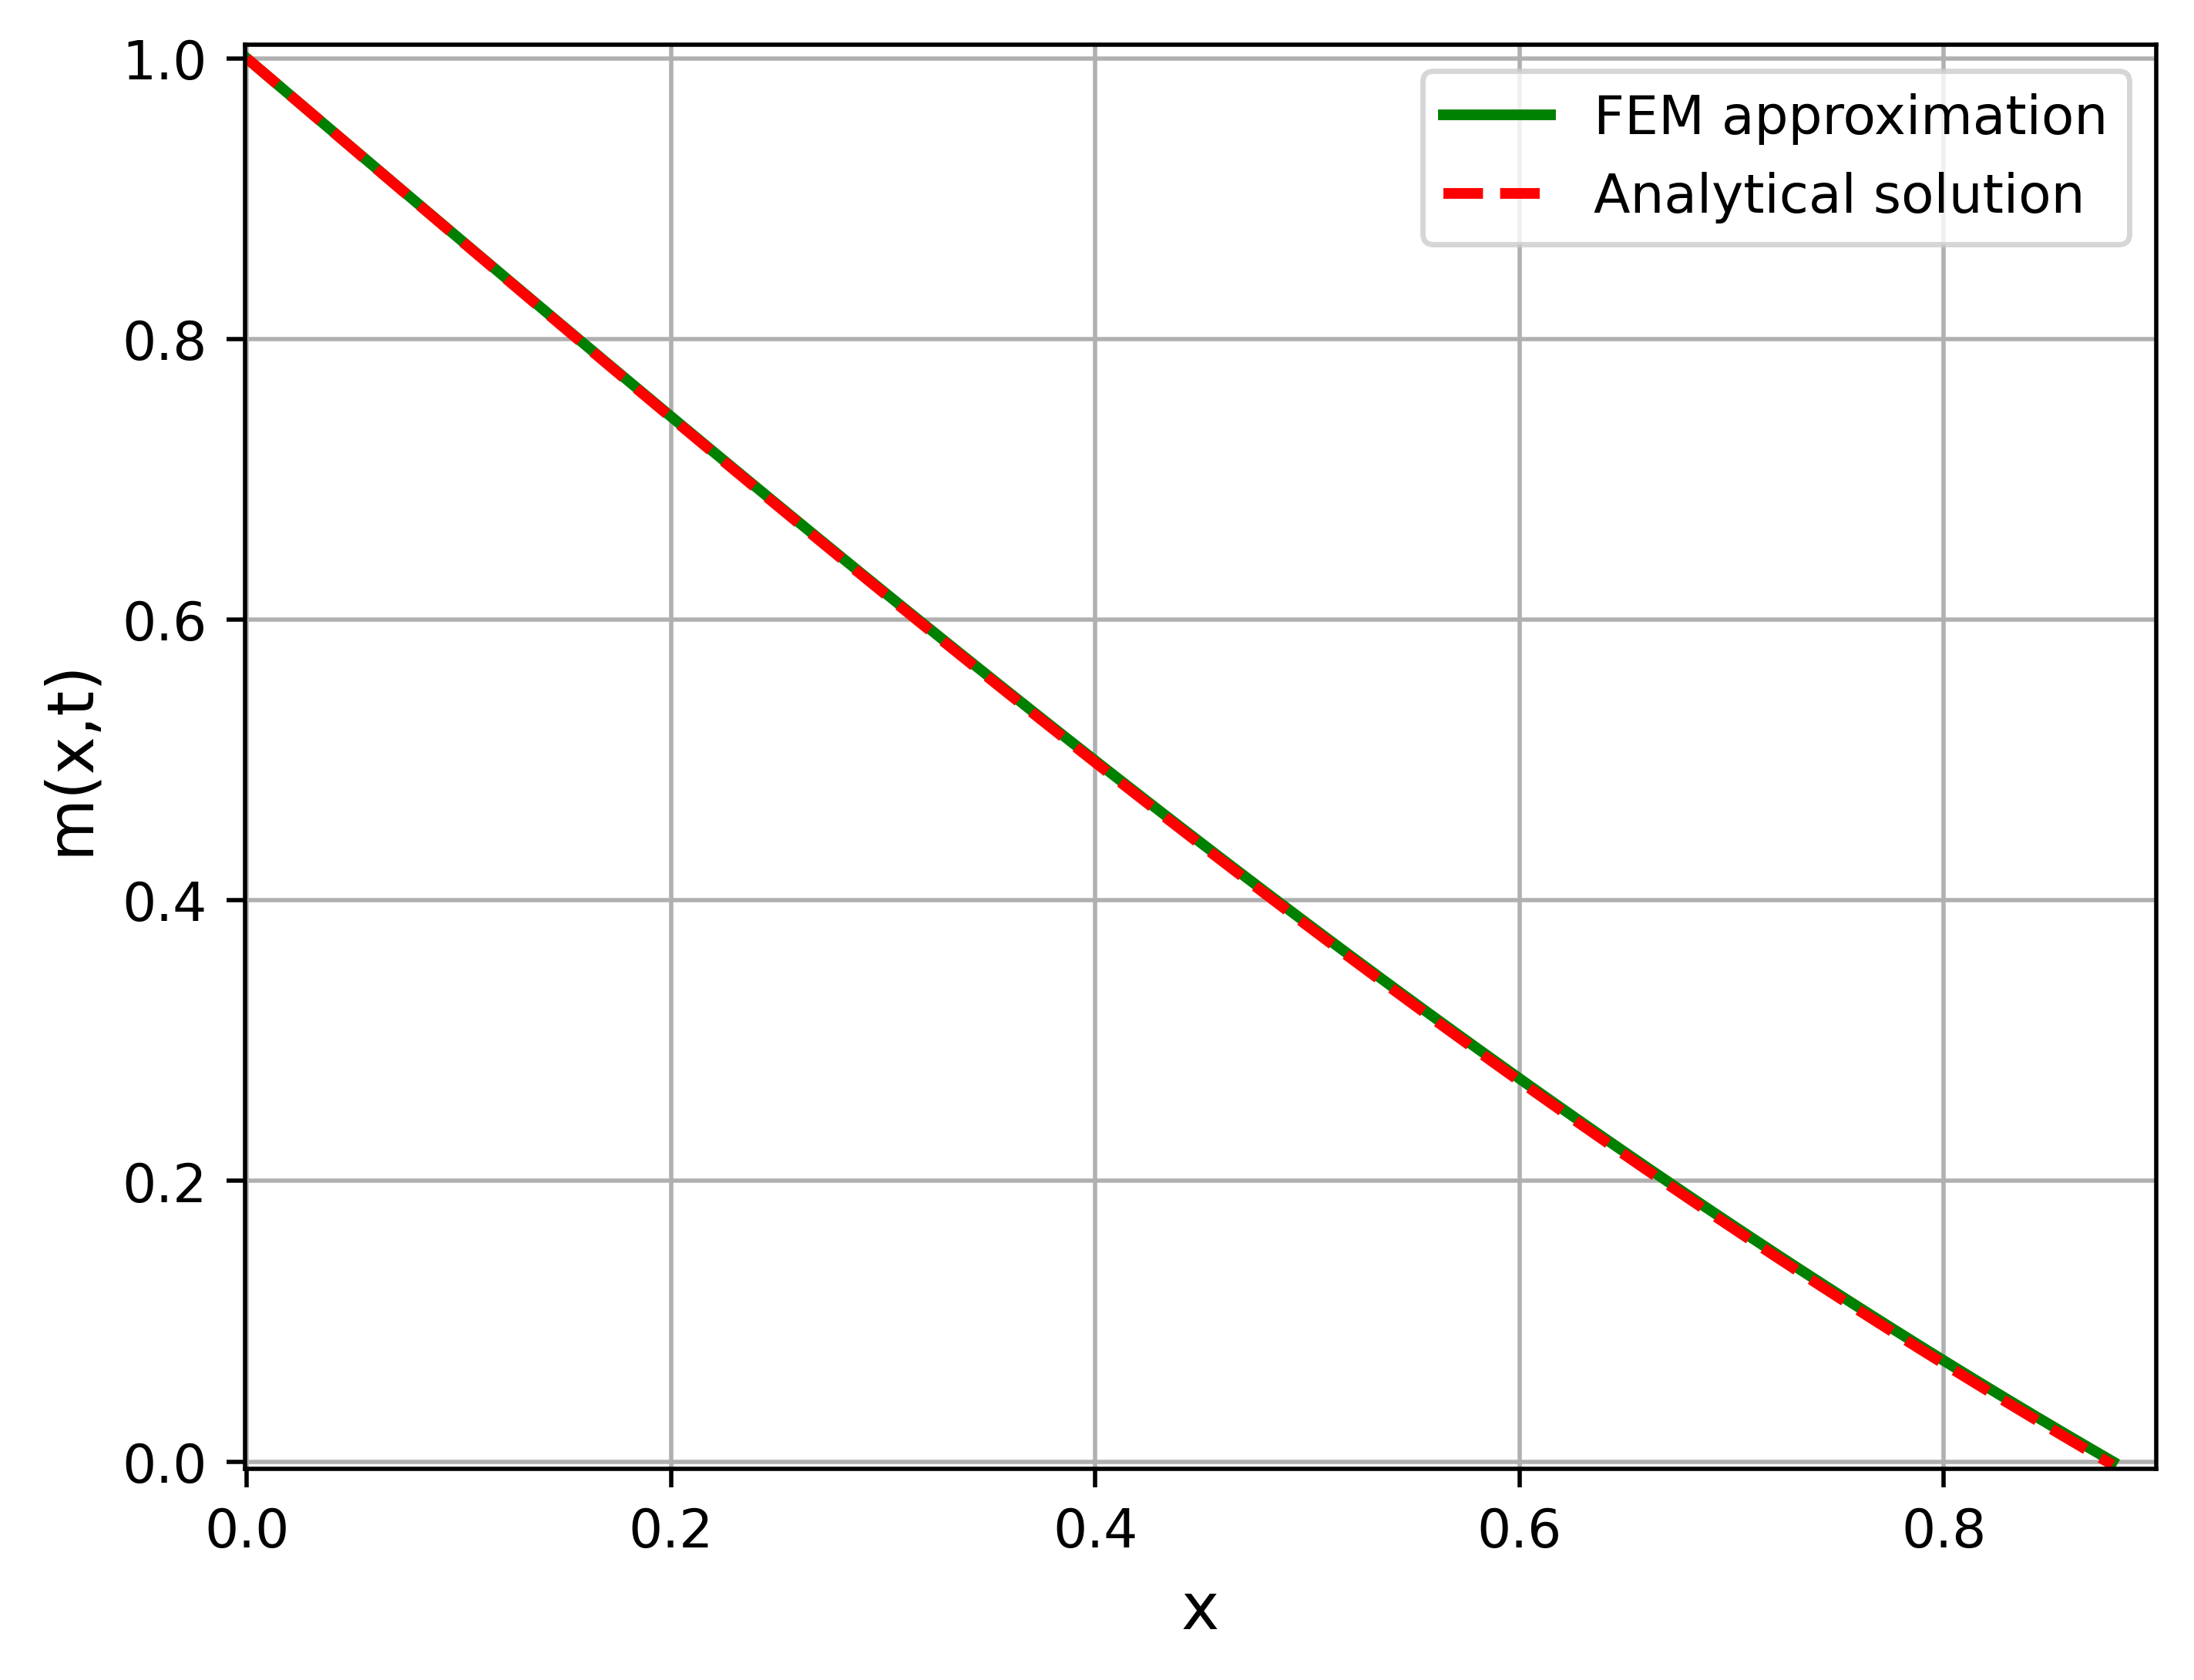

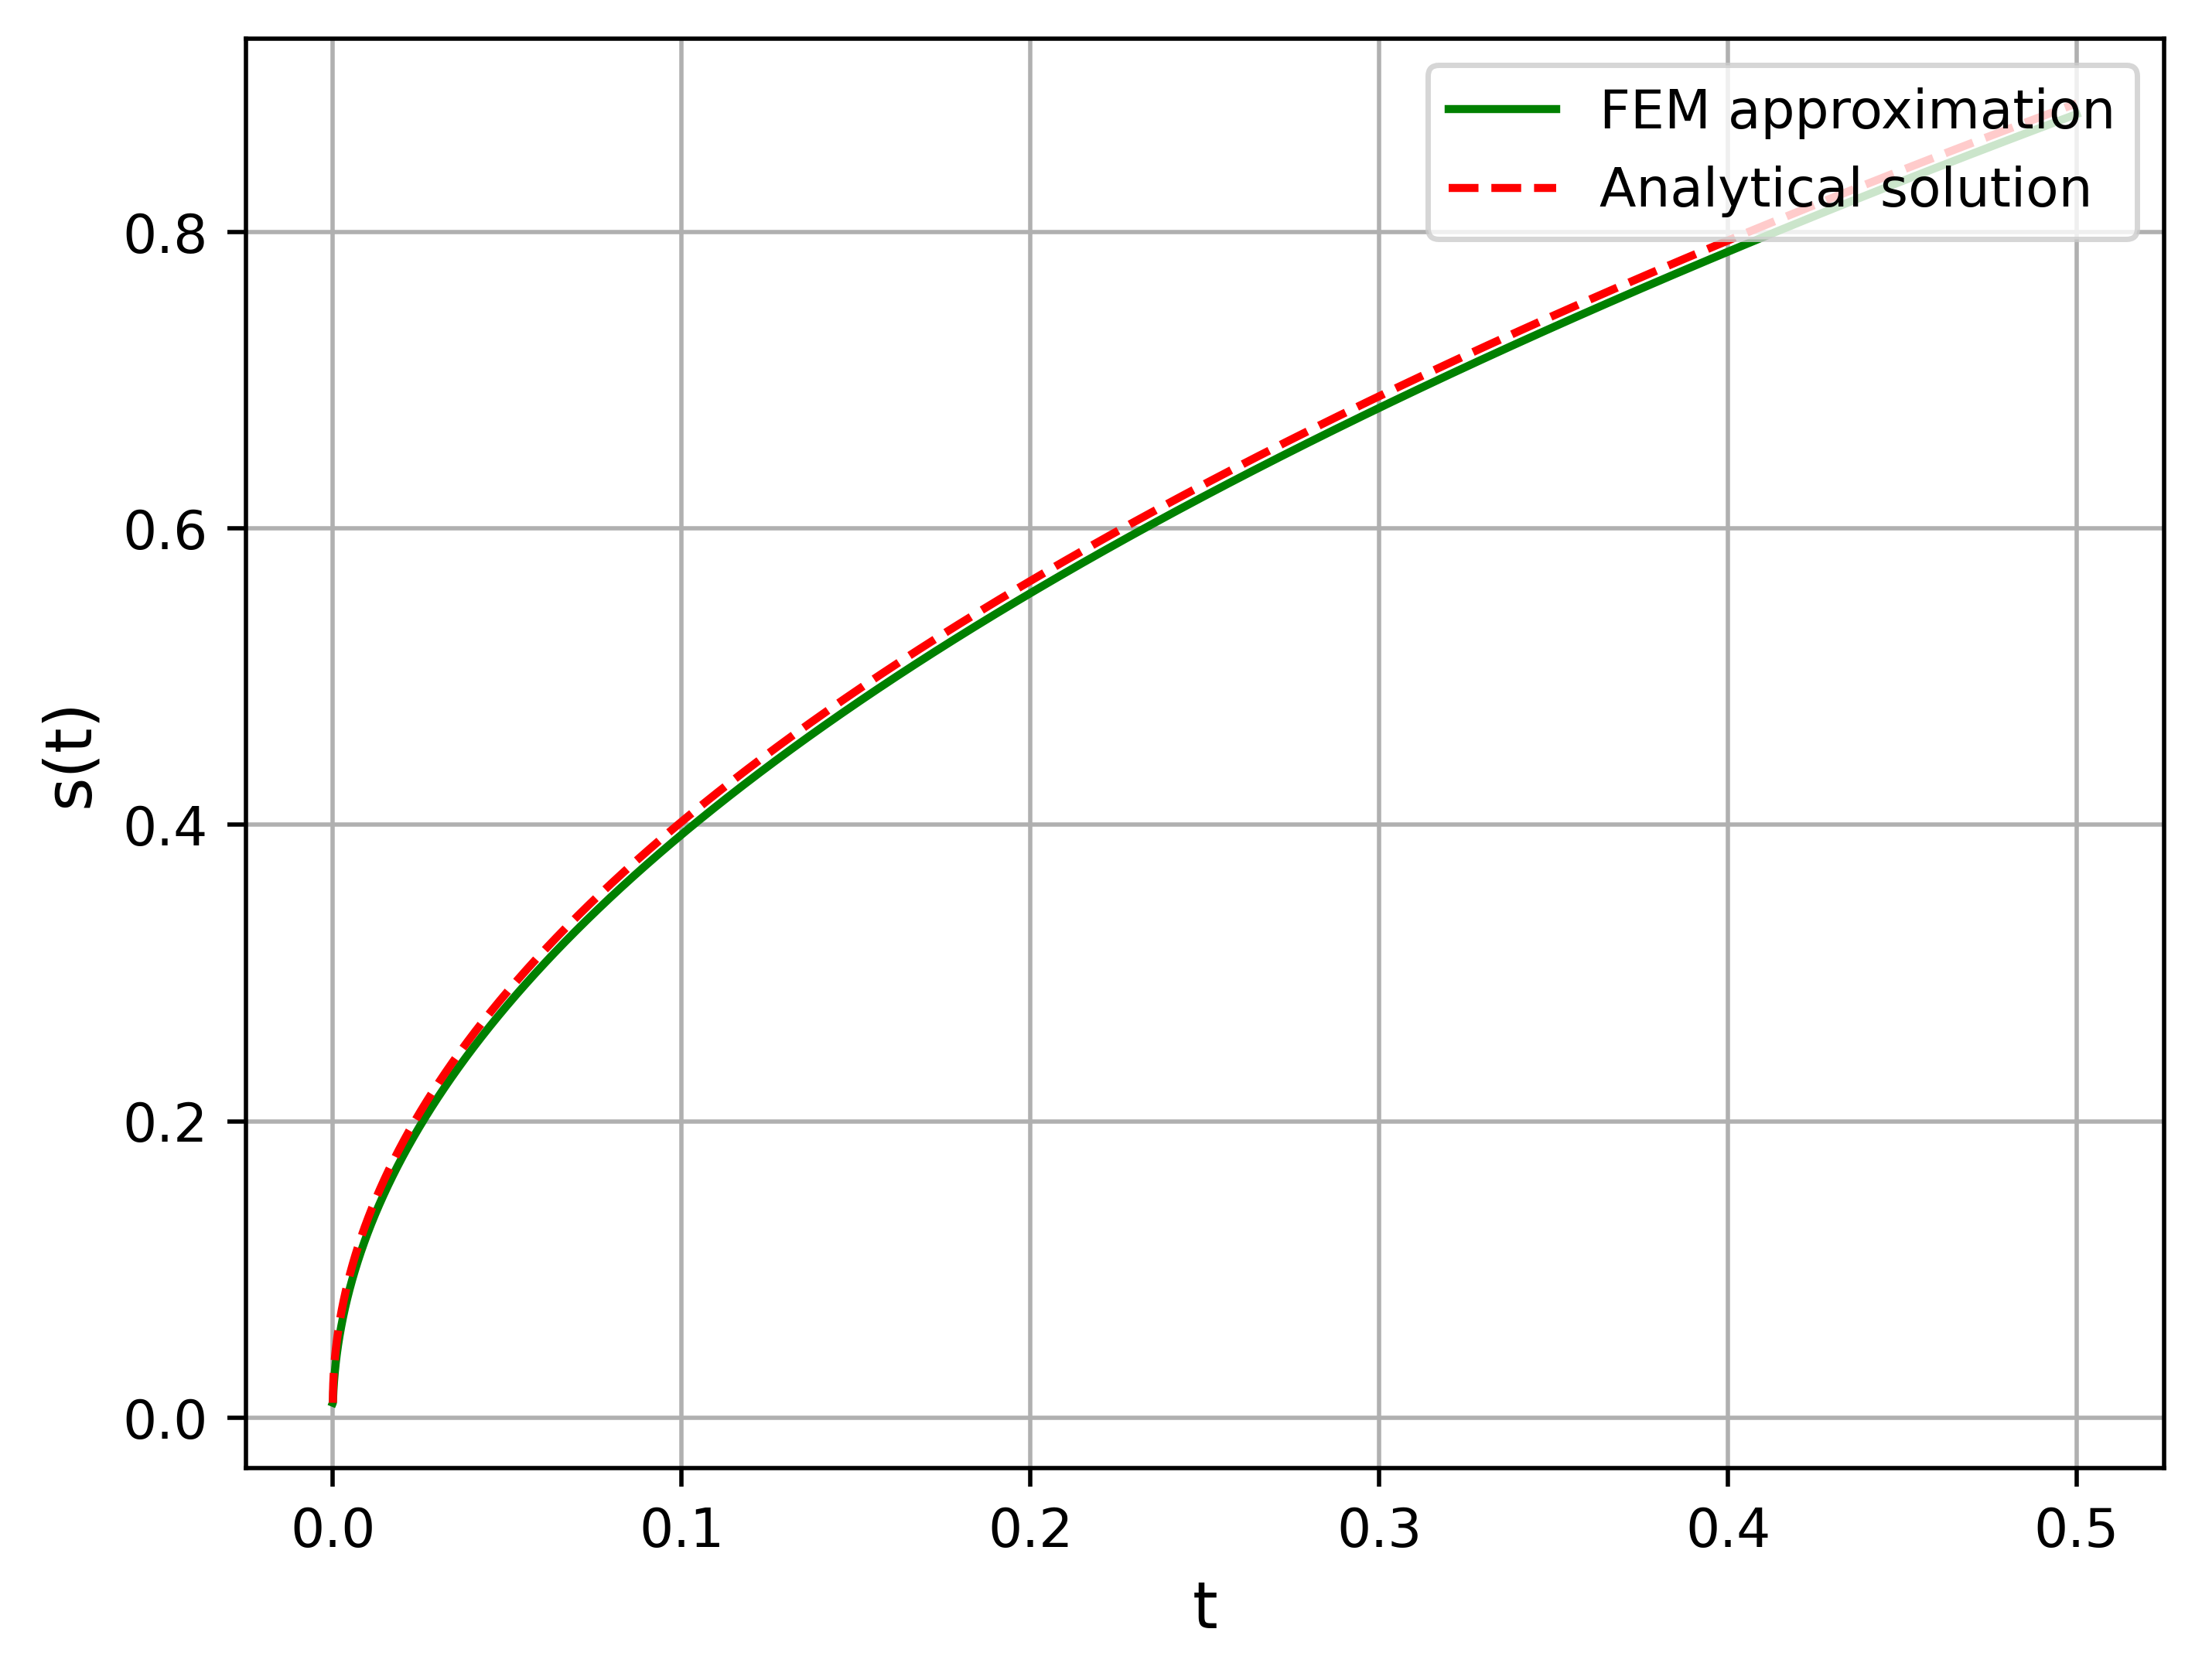

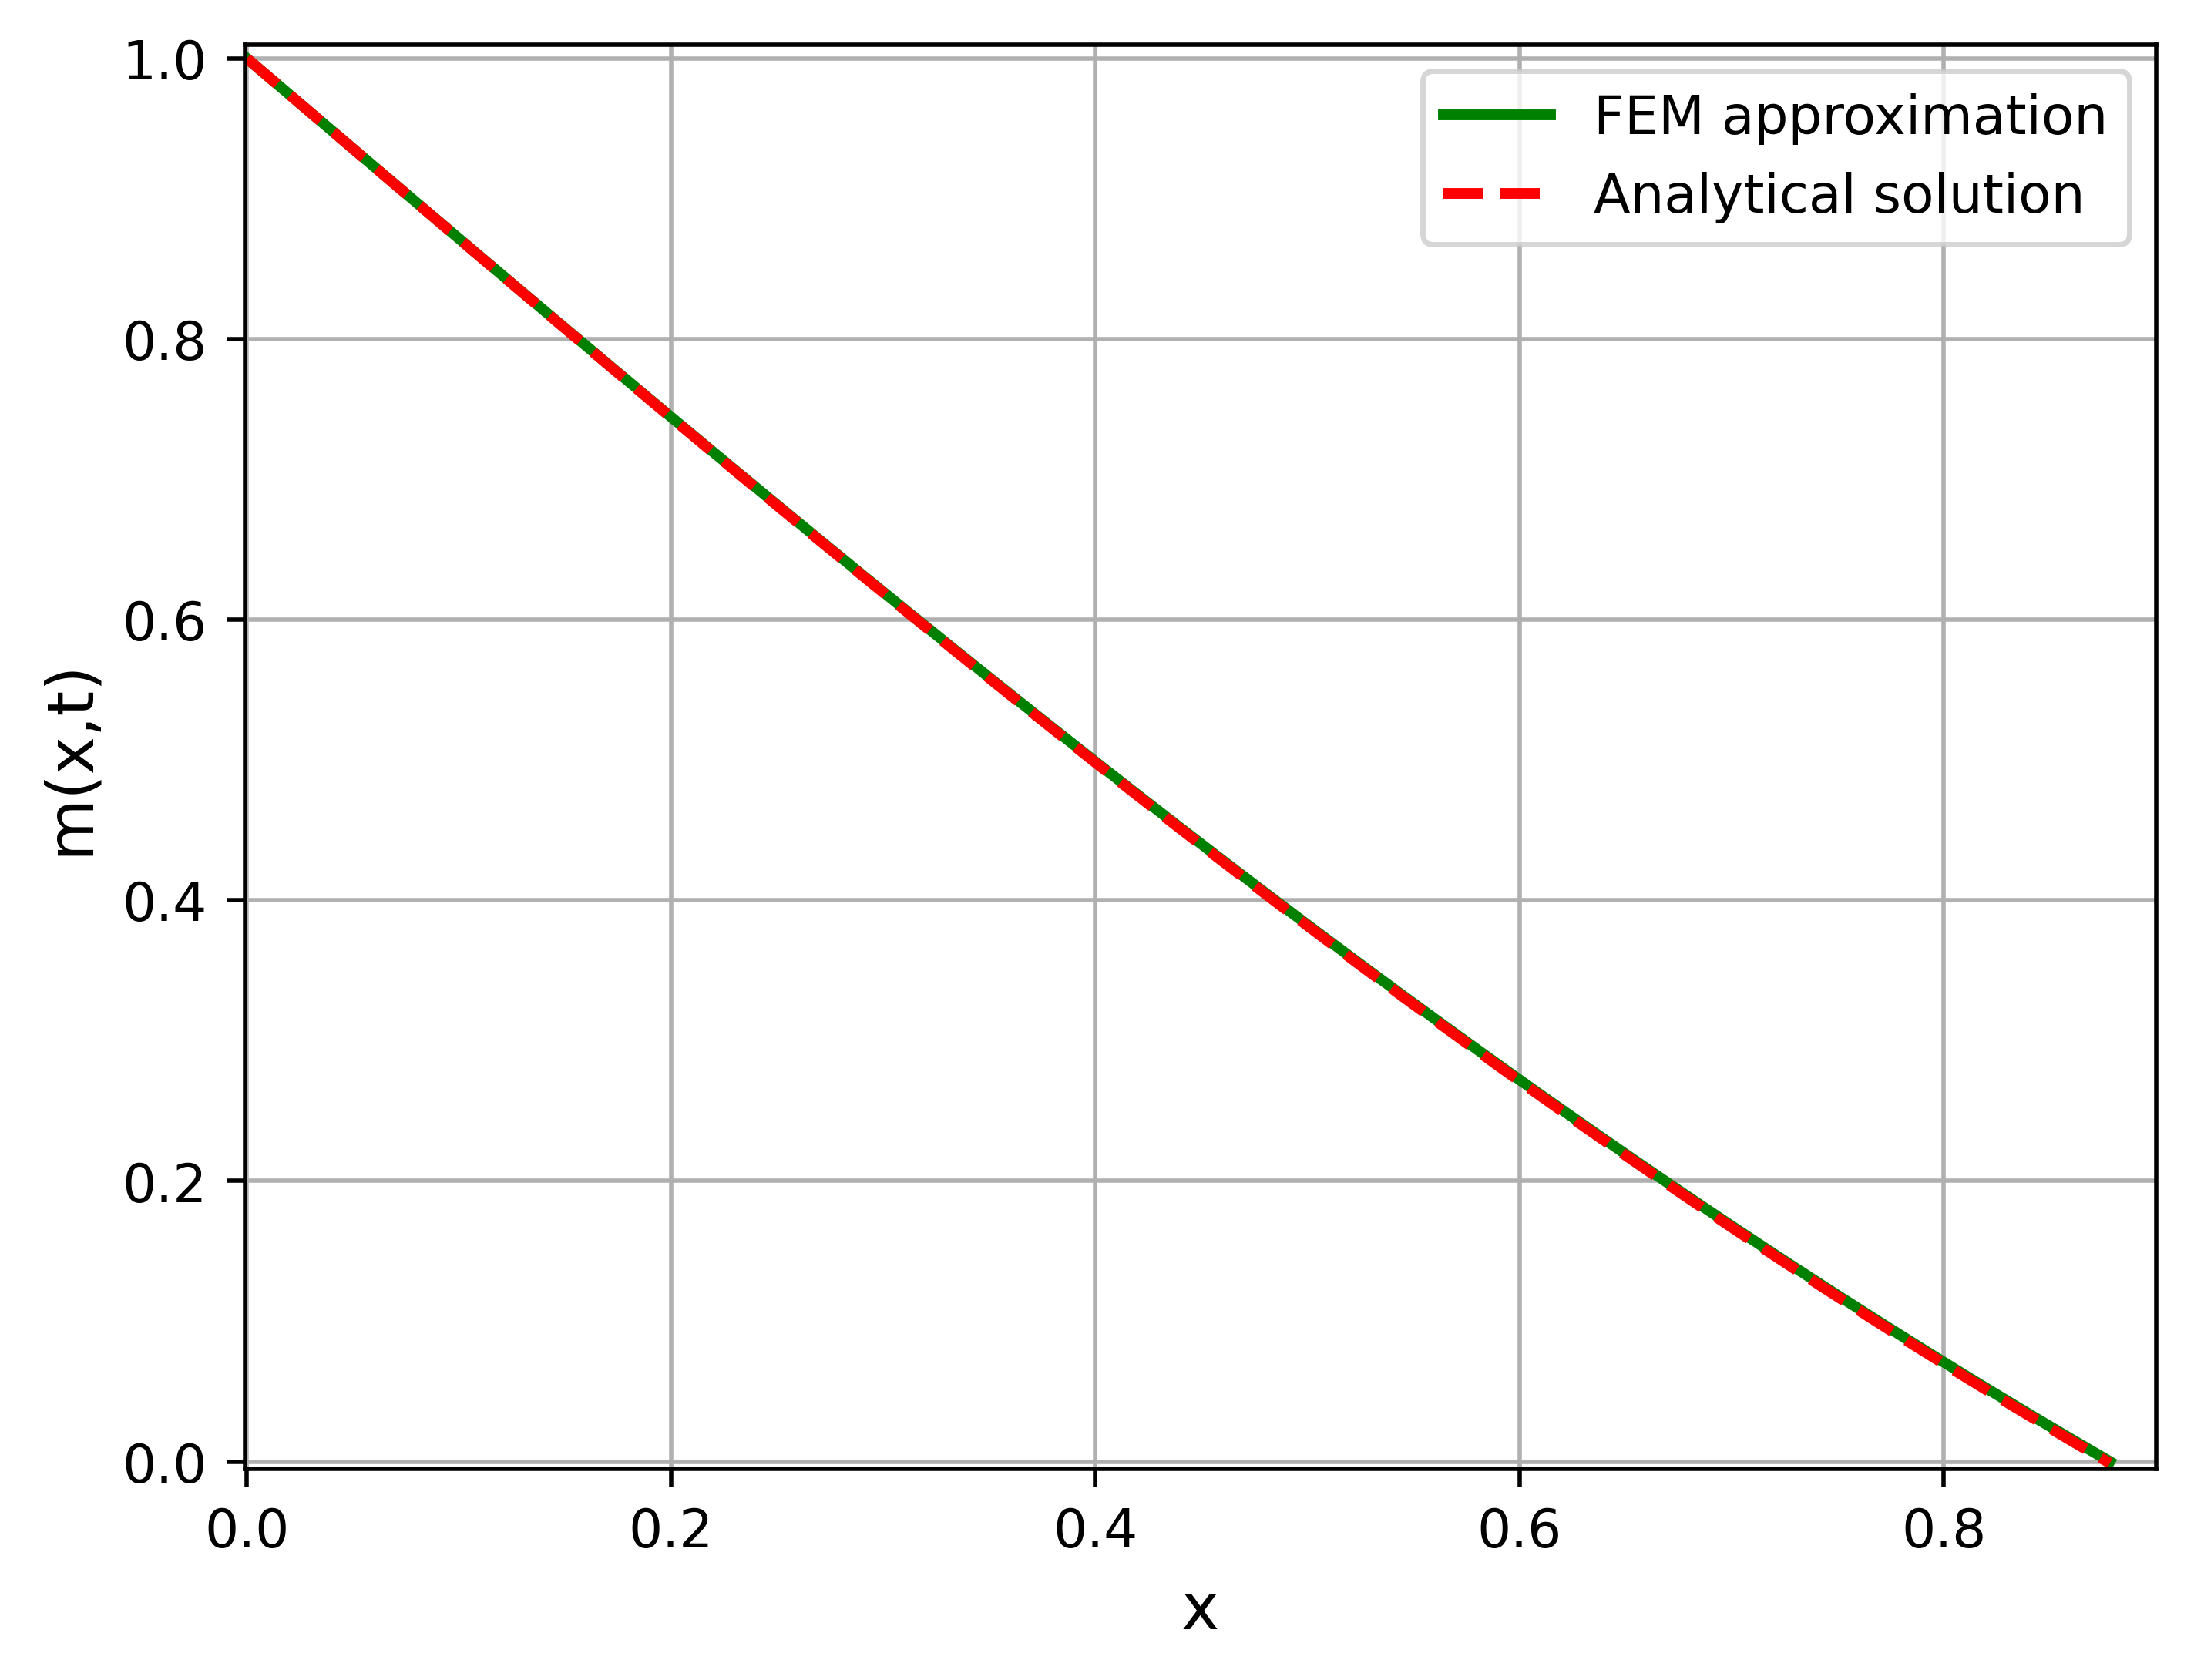

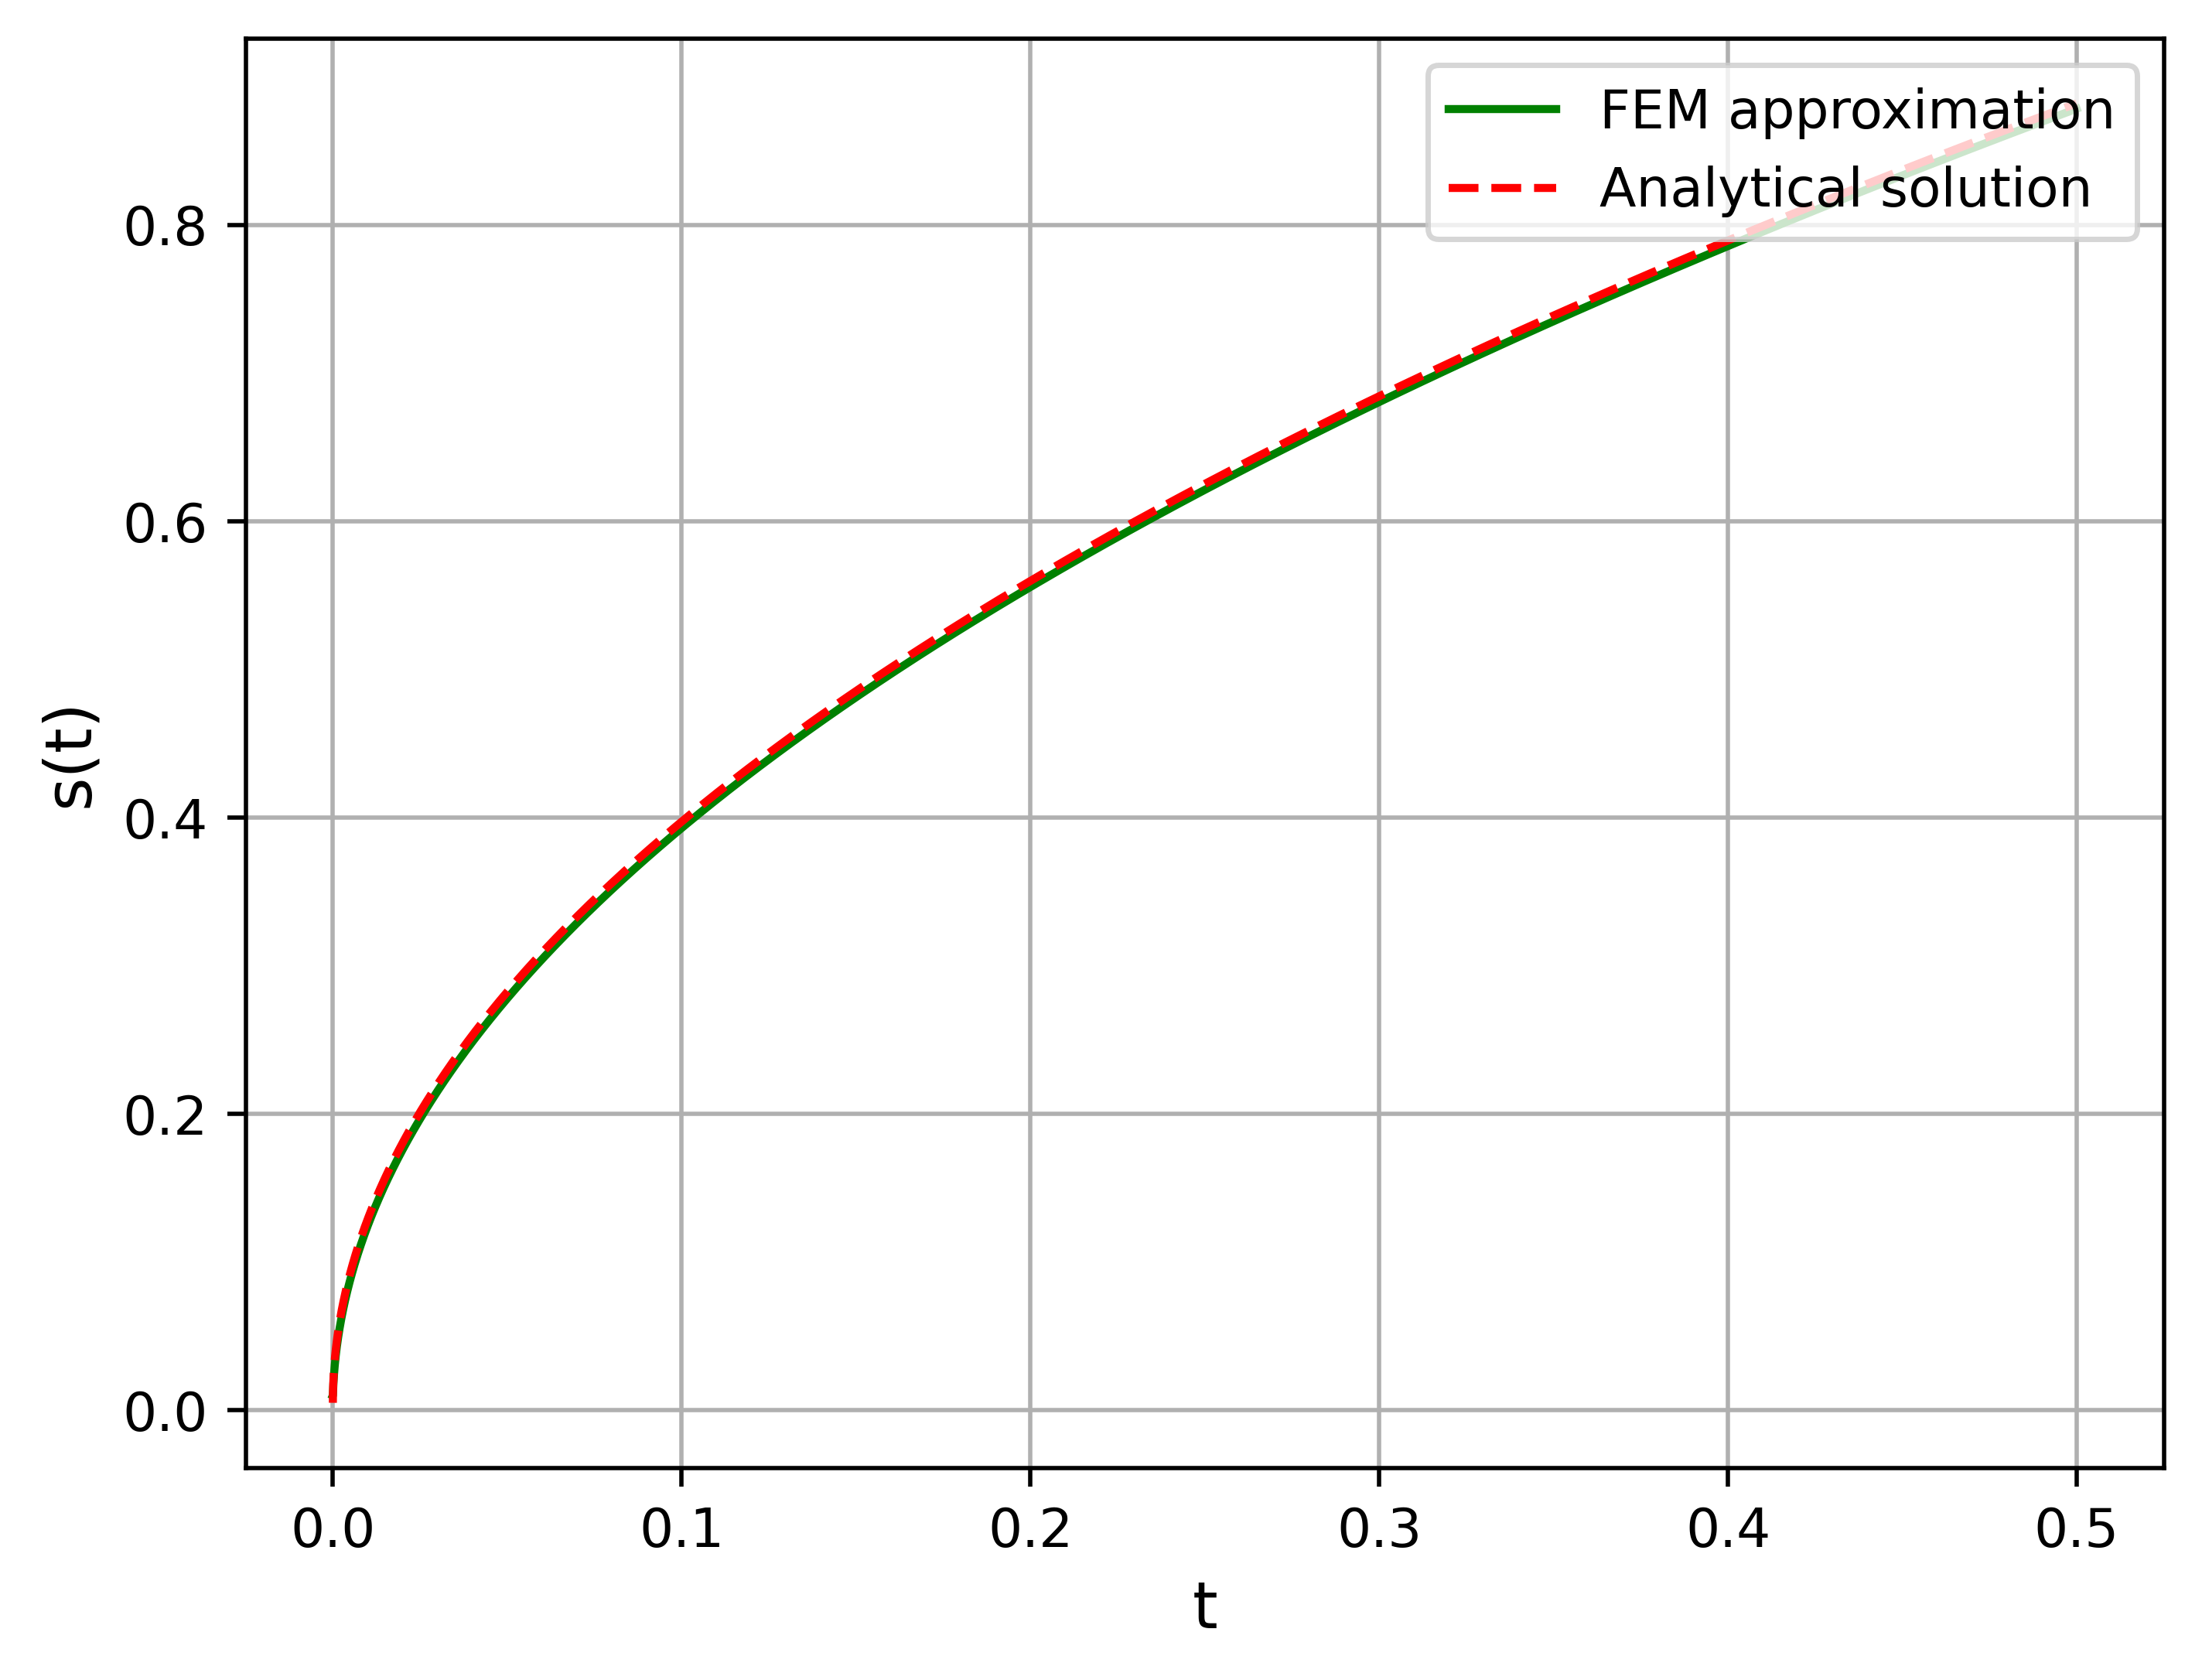

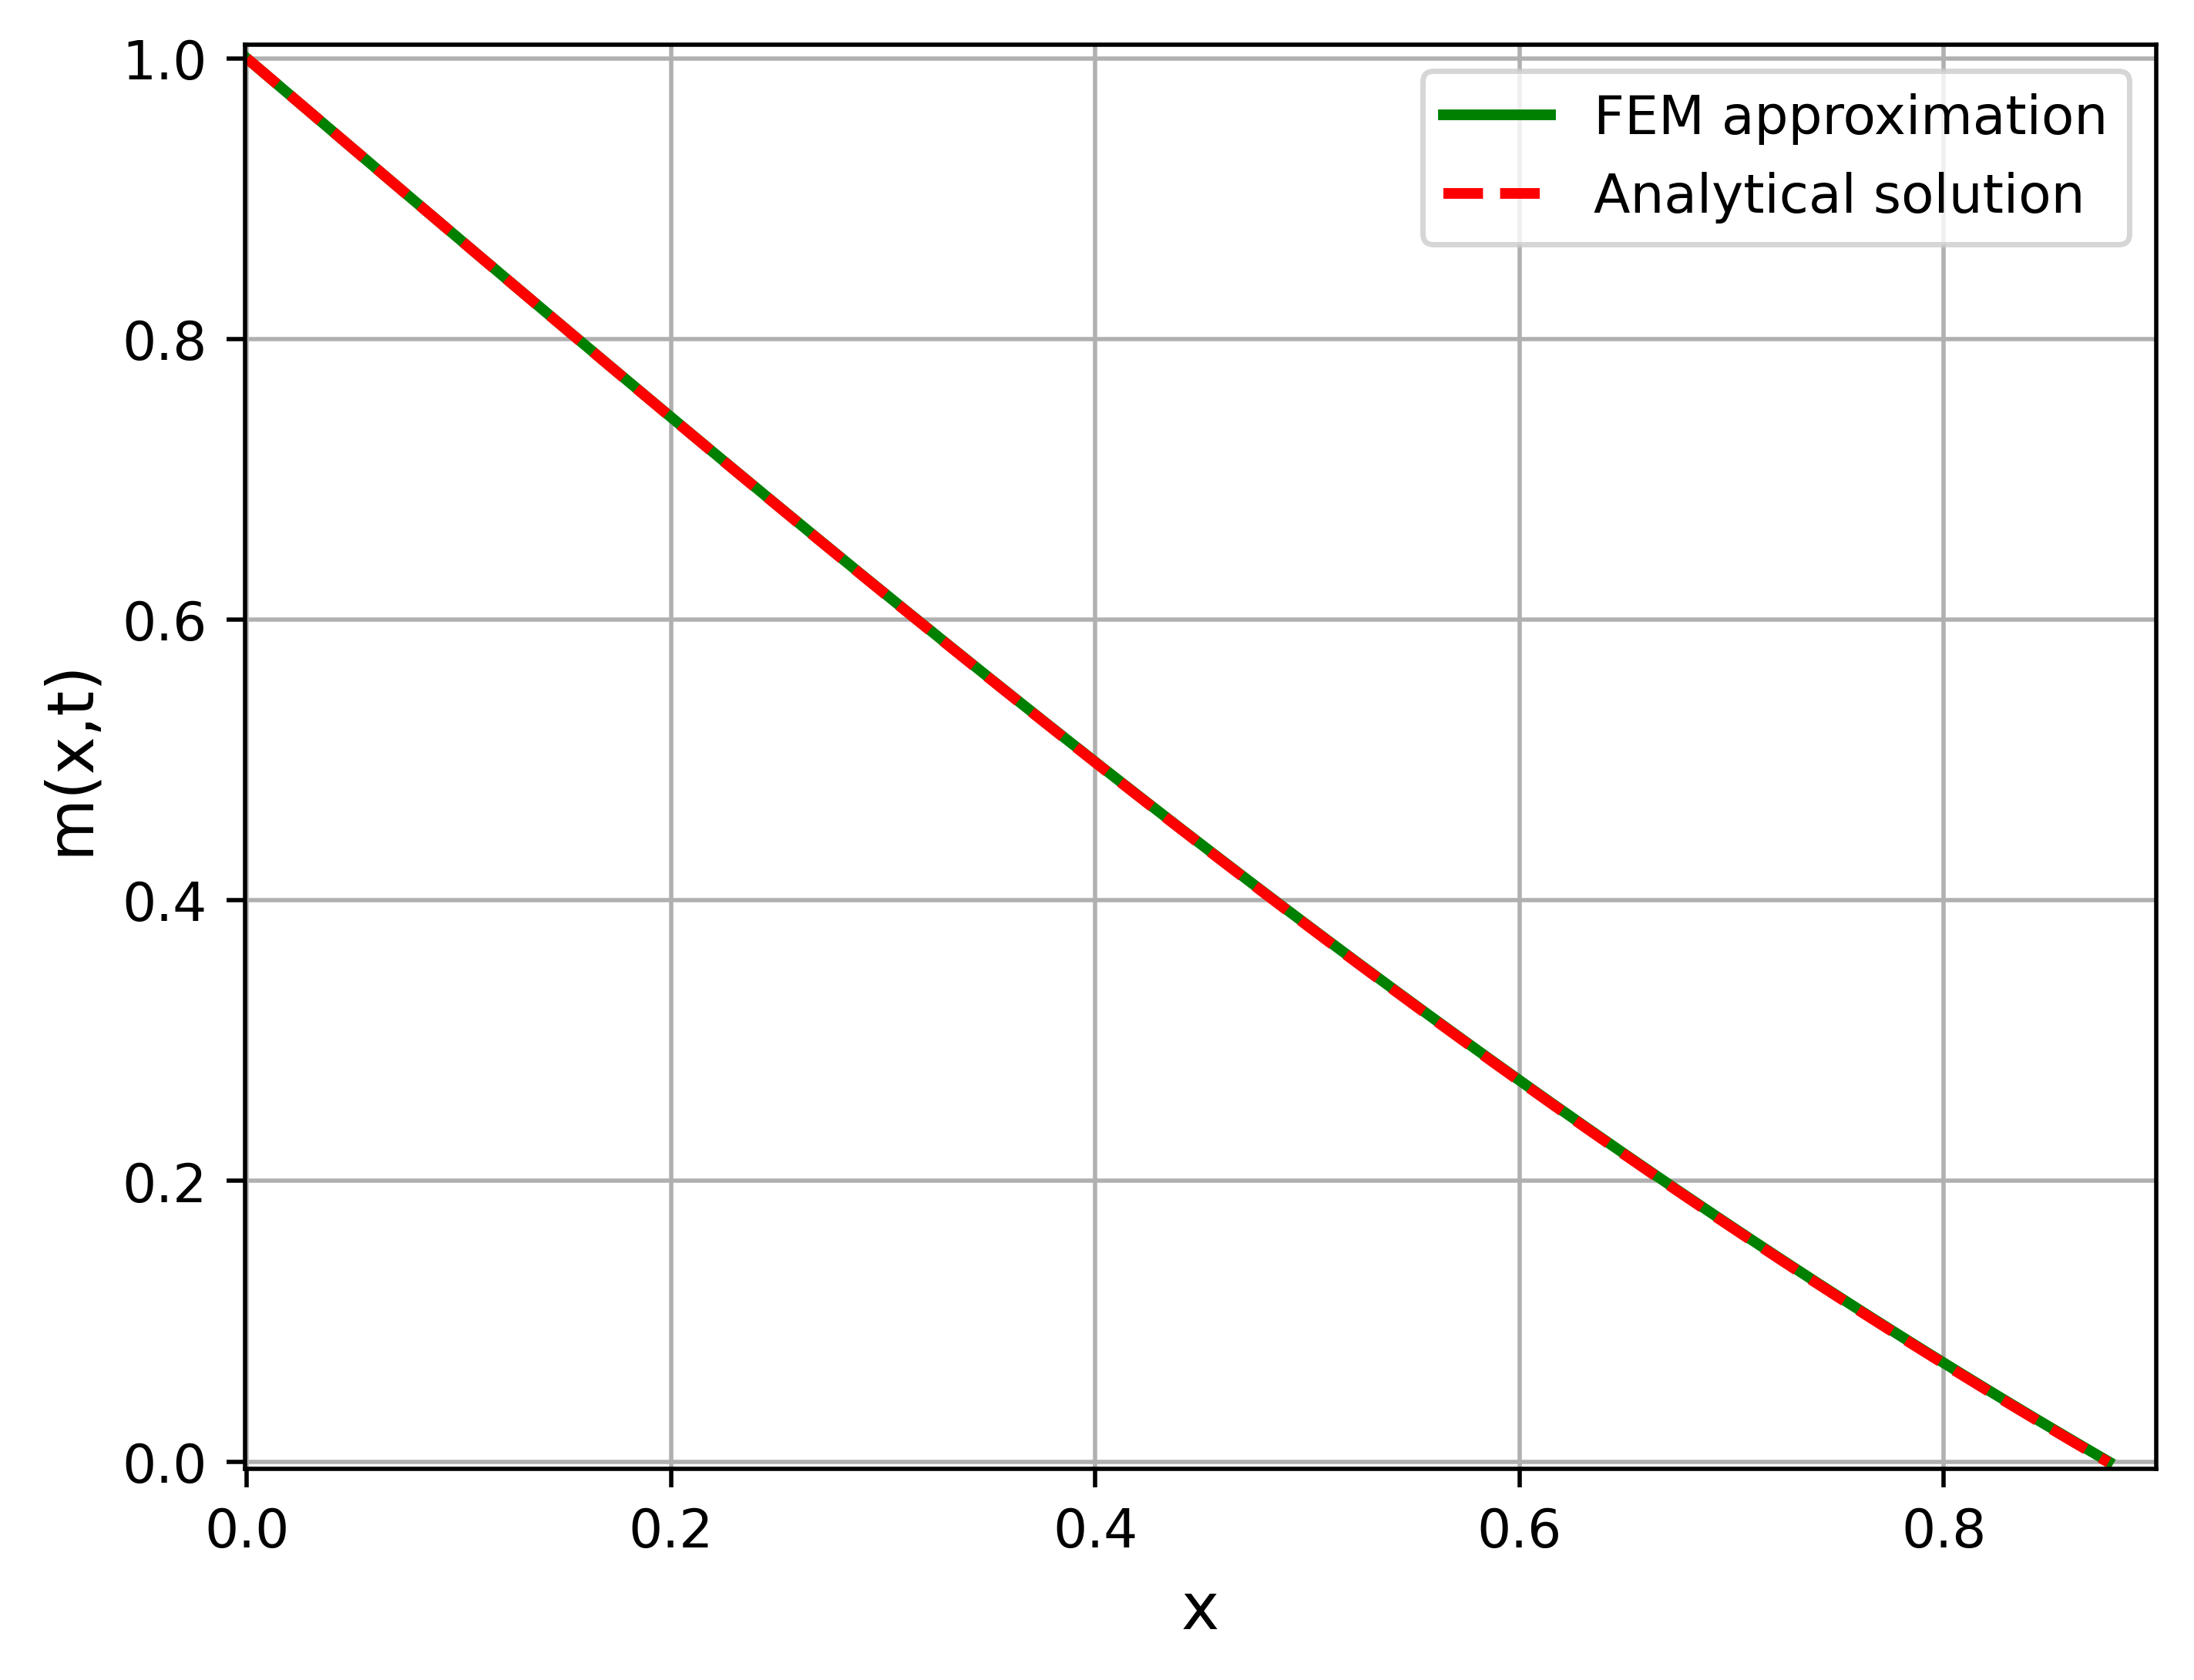

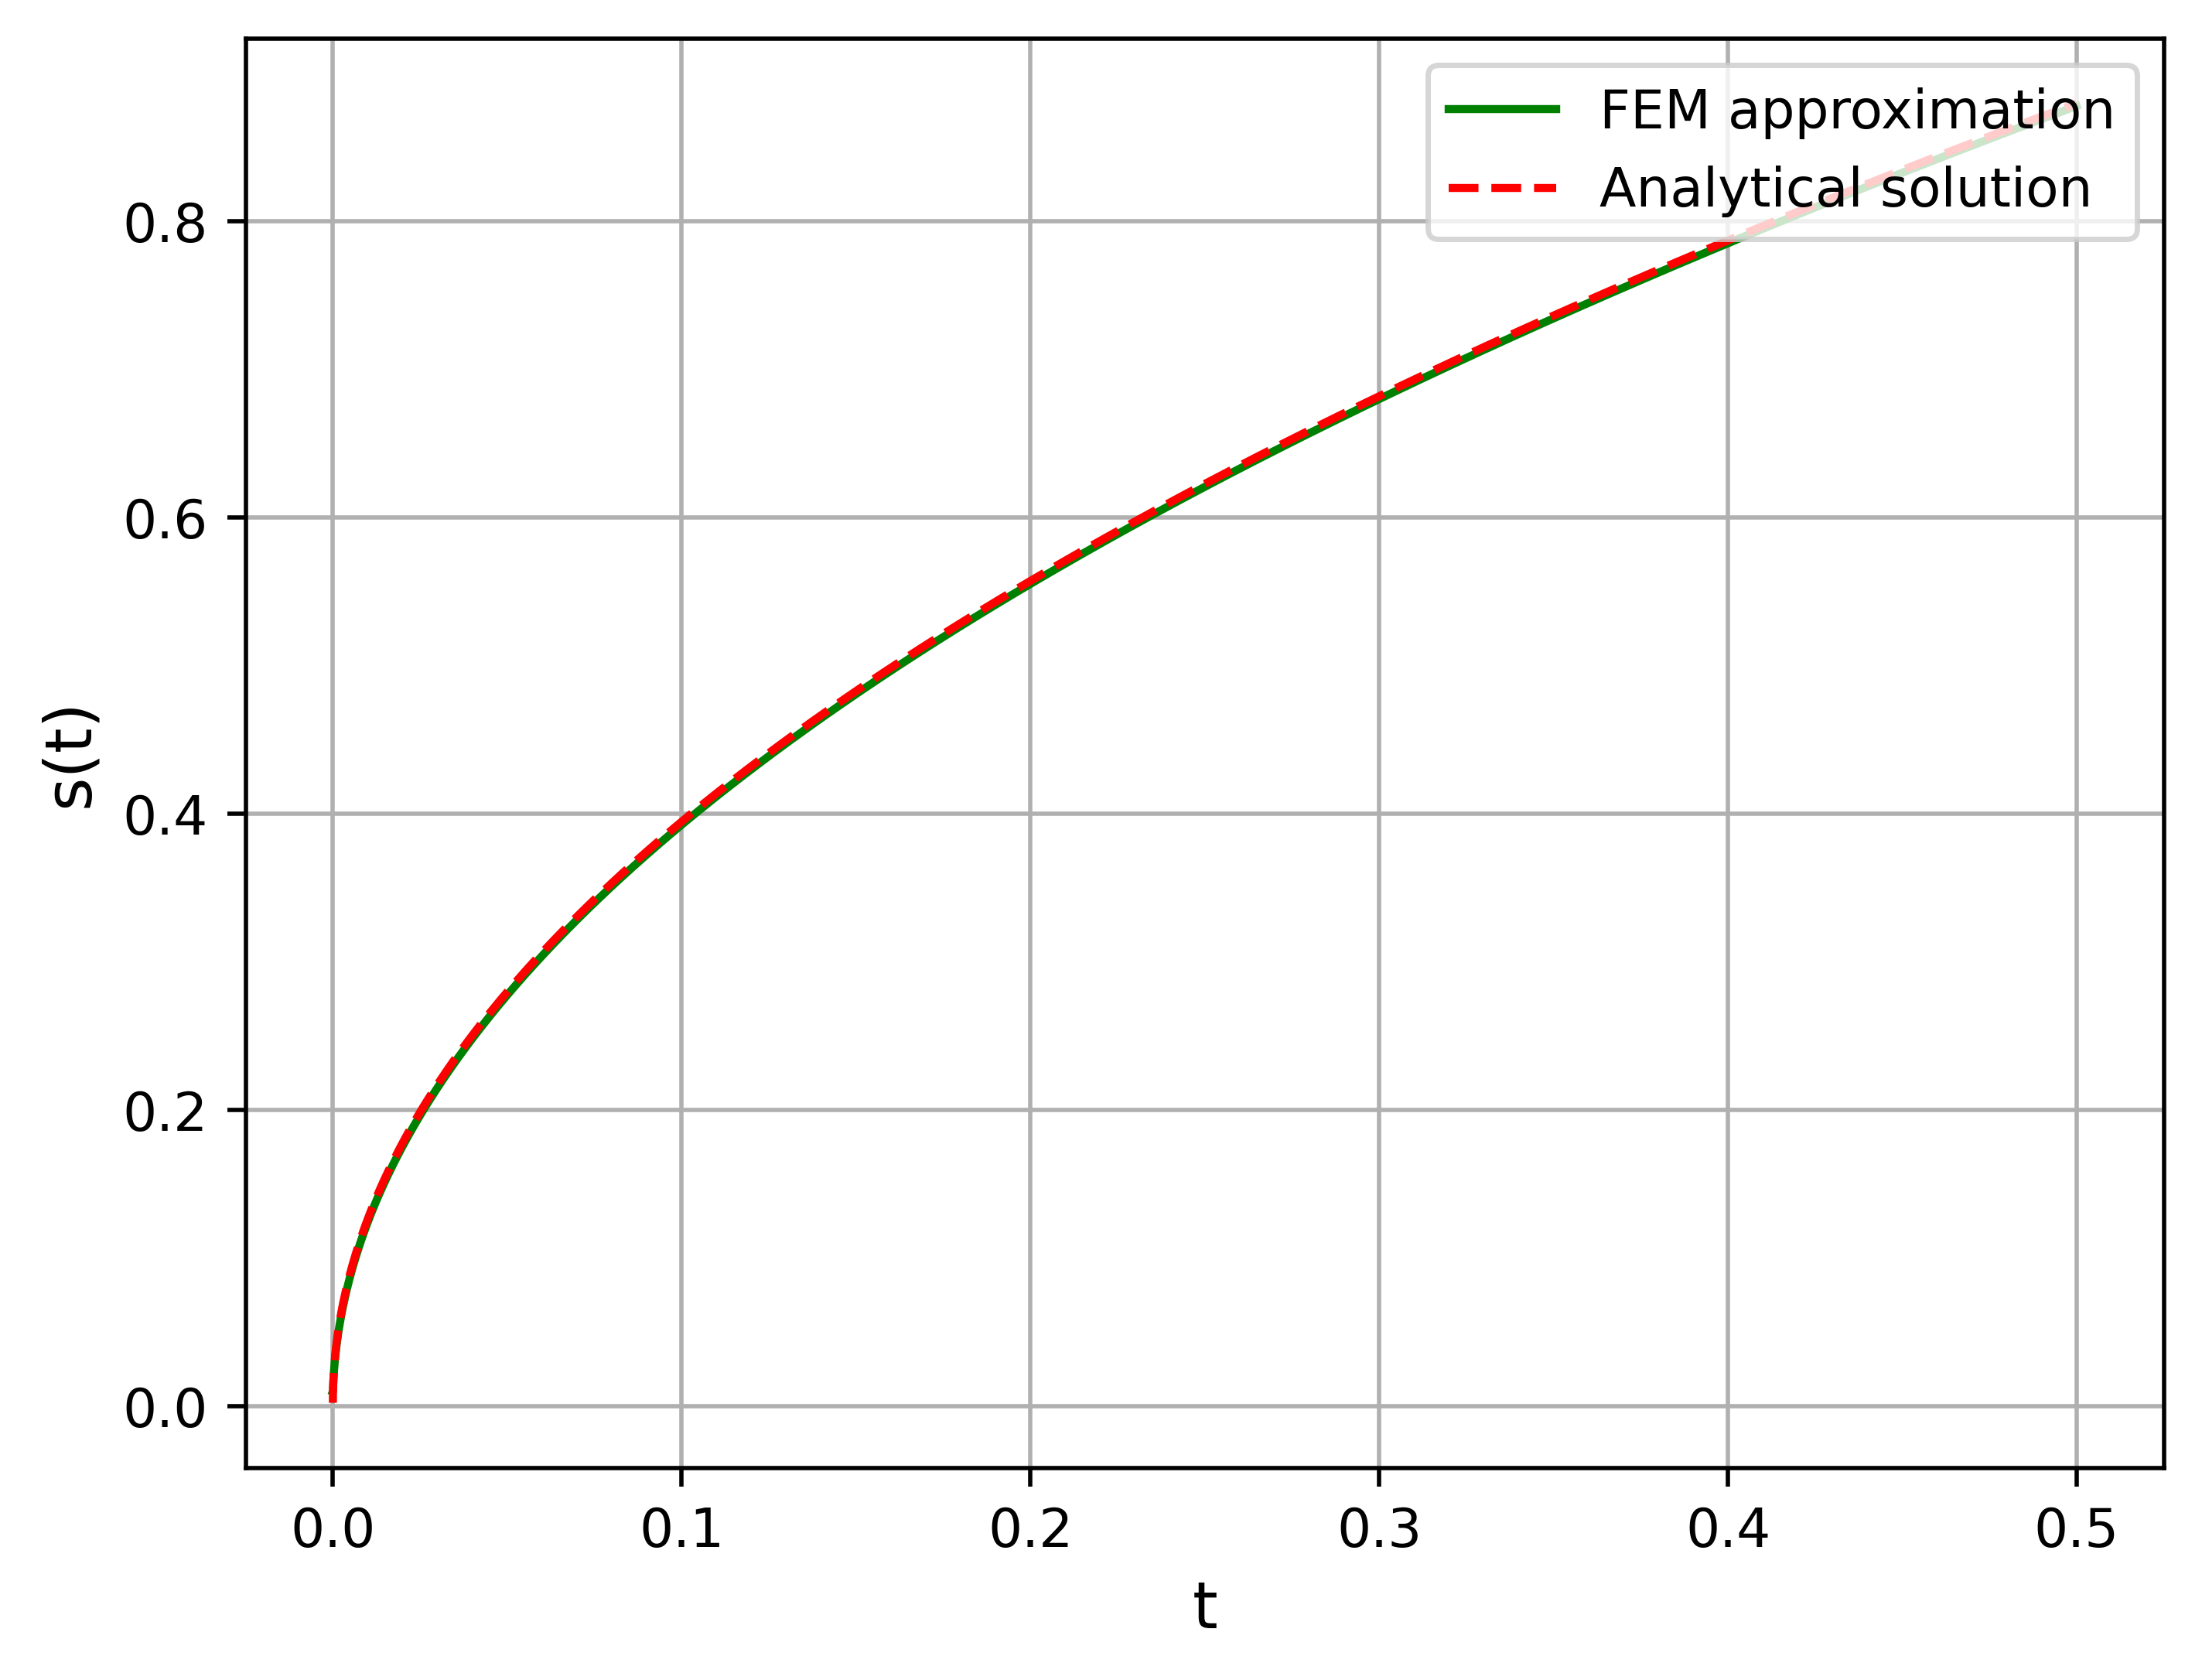

In [6]:
#Stefan problem using FEM 
# This is the Python code for solving the Stefan probllem by FEM to produced Table 2 in our GRW paper. 
#"Global random walk for one-dimensional one-phase Stefan-type moving-boundary problems: Simulation results" 
#by Nicolae Suciu, Surendra Nepal, Yosief Wondmagegne, Magnus Ögren, and Adrian Muntean

#import libraries
from numpy import * 
from pylab import *
from math import ceil, floor, erf
from scipy.io import savemat 
import scipy.sparse  
from scipy.sparse import diags 
from scipy.integrate import odeint 
import matplotlib.pyplot as plt

#parameters 
s_0 = 0.01 
alpha = 1 #diffusion coefficient

#non homogeneous BC at left and right boundaries
u_L = 1 #left boundary 
u_R = 0 #right boundary 

#time discretization
T_f= 0.5 #final time 
Nt = 500001 #number of time nodes
dt = T_f/(Nt-1) #time meshsize
t = linspace(0, T_f, Nt) #temporal nodes

#define a function called 'Stefan' that takes 'N' i.e.,total no of space node as input 
def Stefan(N):
    start_time = time.time()
    x = linspace(0,1, N) #spatial nodes
    h = 1/(N -1) #space meshsize
    
    ##### tridiagonal matrix for time derivative 
    M = diags([h/6, 2*h/3, h/6], [-1, 0, 1], shape=(N-2, N-2)).toarray()  
    Min = linalg.inv(M) 

    #######tridiagonal matrix for (grad(u).grad(phi)) 
    K = diags([-1/h, 2/h, -1/h], [-1, 0, 1], shape=(N-2, N-2)).toarray() 

    ######## tridigonal matrix for mixed term  
    diagonals = zeros((3, N-2))   # 3 diagonals 
    for i in range(1, N-3): 
        diagonals[1,i] = -h/3
    diagonals[1, 0] = -h/3  
    diagonals[1, N-3] = 1/6*(3*x[N-1]-h)    
    for i in range(N-3):     
        diagonals[2,i+1] = x[i+2]/2 - h/3 
    for i in range(N-3):     
        diagonals[0,i] = -x[i+1]/2 - h/3   
    k = array([diagonals[0,0:N-3], diagonals[1,:], diagonals[2,1:]], dtype=object) 
    A = diags(k,[-1,0,1]).toarray() 

    #vectors e_1 and e_{N} (it is needed for boundary terms)
    E1 = (N-2)*[0] 
    E1[0] = 1
    EN = (N-2)*[0]
    EN[N-3] = 1

    #solving matrix      
    def Model(u, t): 
        dwdt = (1/u[N-2])*alpha*u[N-3]/h 
        dudt = (dwdt/u[N-2])*dot(dot(Min, A), u[0:N-2]) - (alpha/(u[N-2])**2)*dot(dot(Min, K), u[0:N-2]) \
              + (-(u_L*dwdt/u[N-2])*(x[0]+2*x[1])/6 + alpha*u_L/((u[N-2])**2*h))*dot(Min,E1) \
              +  ((u_R*dwdt/u[N-2])*(x[N-1]+2*x[N-2])/6 - alpha*u_R/((u[N-2])**2*h))*dot(Min,EN) 
        dudt = list(dudt) 
        dudt.append(dwdt) 
        return dudt

    #initial conditions
    u0 = (N-2)*[0] 
    u0.append(s_0)

    #solve ODE 
    z = odeint(Model, u0, t)

    # we need to add the fix value at the Dirichlet boundary 
    Dirichelt_BC_left = (Nt)*[u_L]
    Dirichelt_BC_right = (Nt)*[u_R]
    index=0
    mm=np.insert(z, index, Dirichelt_BC_left, axis=1)
    m =np.insert(mm, N-1, Dirichelt_BC_right , axis=1)
    
    hh=m[:,-1] # extracting the data of moving boundary
    hhh = np.array(hh)
    #savemat("matlab_data_st.mat", {"array": hhh})
    
    ######trasnfering back to moving doamin 
    md = np.multiply(x,np.transpose([hh])) #moving domain over time 
    
    ###computing exact solution 
    beta = 1
    def trans_eq(beta, T_0):
        f = lambda x: np.sqrt(np.pi)*beta*x*np.exp(x**2)*erf(x)-T_0
        fprim = lambda x: beta*(np.sqrt(np.pi)*np.exp(x**2)*erf(x)*(2*x**2+1)+2*x**2)
        tol=1e-6
        x0=1
        while abs(f(x0)) > tol:
            x0 = x0-f(x0)/fprim(x0)
        return x0
    Lambda = trans_eq(beta, u_L)

    def s(t):
        return h + 2*Lambda*np.sqrt(alpha*t)
    
   #define error function
    def error(x):
        return erf(x)
    vector_err = np.vectorize(error) 

    def function(x, time):
        return u_L*(1-vector_err(x/(2*np.sqrt(alpha*time)))/erf(Lambda))

    xx = np.linspace(0, s(T_f), N) #discretize space domain (0,s(t)) for plotting the analytical solution
    h_max = xx[1]-xx[0] #h_max is required in computing error 
    end_time = time.time()
    computation_time = end_time- start_time
    print('computation time =', computation_time)

    #####error 
    # take square of differences and sum them
    l2_norm = np.sum(np.power((hh - s(t)),2))

    # take the square root of the sum of squares to obtain the L2 norm
    L2_norm_mv = np.sqrt(dt*l2_norm)
    
    U_ex = [] #lnitialize empty list for exact solution
    
    ####error for concentration profile
    for i in range(len(t)-1):
        Nodes = np.linspace(0, s(t[i+1]), N) # discretize (0, s(t)) with N discrete node 
        u_ex = function(Nodes, t[i+1]) #comoute exact solution at xxx with different time nodes
        U_ex.append(u_ex)
    L2_norm_u = np.sqrt(dt*h_max*np.sum(abs(U_ex - m[1:, :-1])**2))
    L2_norm = [L2_norm_mv, L2_norm_u] #L_2 norm for moving boundary and L_2 norm for u
    
    ###########  plot finite element and exact solutions
    #plot the temperature profile
    fig = plt.figure(dpi=500)
    plt.plot(md[Nt-1, :], m[Nt-1, :-1], 'g-',linewidth=2) #finite element solution 
    plt.plot(md[Nt-1, :], function(md[Nt-1, :], T_f), 'r--',linewidth=2) #analytical solution
    plt.xlabel('x', fontsize=12)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('m(x,t)', fontsize=12)
    xlim(-0.001, 0.9)
    ylim(-0.005, 1.01)
    plt.legend([r"FEM approximation",r"Analytical solution"], loc='upper right', frameon=True)
    plt.grid()
    #plt.show() #uncomment this if you want to see the plot

    #plot the moving boundary
    fig = plt.figure(dpi=500)
    plt.plot(t, hh, 'g-')
    plt.plot(t, s(t), 'r--')
    plt.xlabel('t', fontsize=12)
    plt.ylabel('s(t)', fontsize=12)
    plt.legend([r"FEM approximation",r"Analytical solution"], loc='upper right', frameon=True)
    plt.grid()
    #plt.show() #uncomment this if you want to see the plot
    return L2_norm

#We compute solution for different mesh size with space node N ≈ [26, 51, 101, 201, 401]
NN = [26, 51, 101, 201, 401]
Error_l2 = []
for N in NN:
    L_2 = Stefan(N)
    Error_l2.append(L_2)
    
#computing order of convergence
import math
print(Error_l2)
for i in range(len(Error_l2)-1): 
    convergecne_order_mv = round(math.log(Error_l2[i][0]/Error_l2[i+1][0])/math.log(2), 2)
    convergecne_order_u =round(math.log(Error_l2[i][1]/Error_l2[i+1][1])/math.log(2), 2)
    print('convergence order for s(t)=', convergecne_order_mv)
    print('convergence order for u =', convergecne_order_u)    